In [3]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

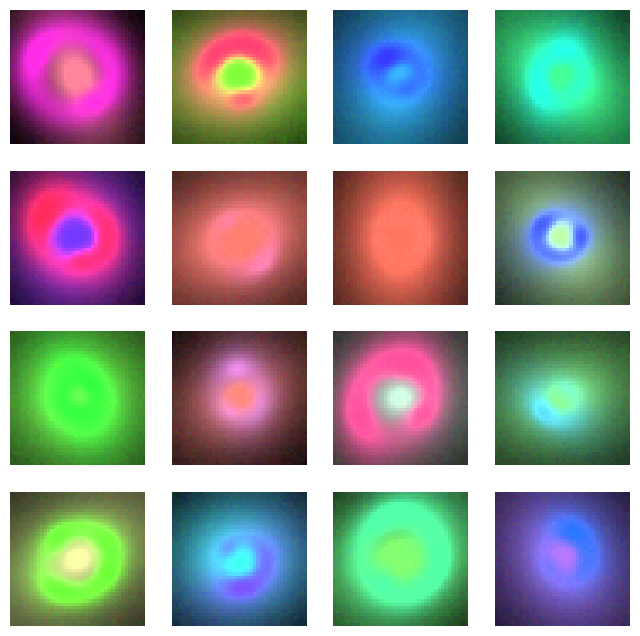

In [5]:
# Visualize source data
visualize_data(source_data)

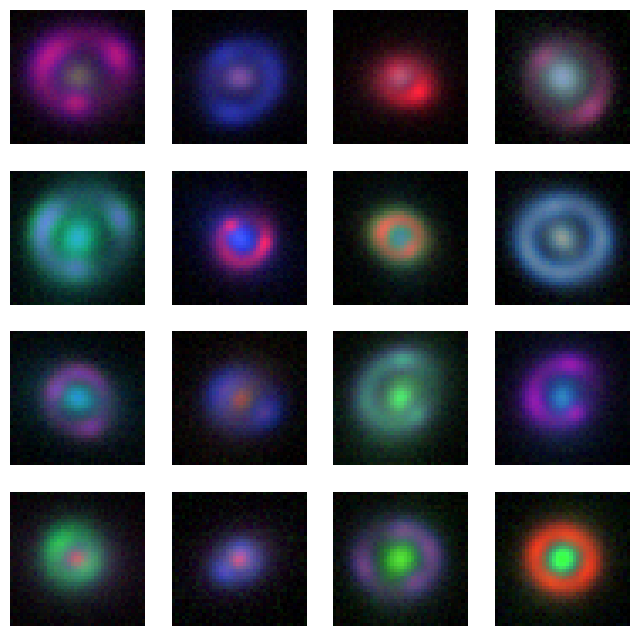

In [6]:
# Visualize target data
visualize_data(target_data)

In [7]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self, npix):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=2))

        self.npix = npix

    def forward(self, x):
        x = x.view(-1, 3, self.npix, self.npix)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1, 2)

        return estimate, features


    def get_feature(self, x):
        x = x.view(-1, 3, self.npix, self.npix)
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        return features

In [8]:
def loss_bnll(mean, variance, truth, beta, epsilon = 1e-7):  # beta=0.5):
    """Compute beta-NLL loss

    :param mean: Predicted mean of shape B x D
    :param variance: Predicted variance of shape B x D
    :param truth: truth of shape B x D
    :param beta: Parameter from range [0, 1] controlling relative
        weighting between data points, where `0` corresponds to
        high weight on low error points and `1` to an equal weighting.
    :returns: Loss per batch element of shape B
    """
    variance = variance + epsilon
    loss = 0.5 * ((truth - mean) ** 2 / variance + variance.log())
    if beta > 0:
        loss = loss * (variance.detach() ** beta)
    return loss.sum(axis=-1) / len(mean)

In [9]:
# Define training loop
def train_loop(source_dataloader, 
               target_dataloader, 
               model, 
               regressor_loss_fn,
               da_loss,
               optimizer,
               n_epoch,
               epoch,
               init_wt_da,
               final_wt_da,
               beta_init,
               beta_final):
               # init_wt_mve,
               # final_wt_mve):
    """
    Trains the Neural Network on Source/Target Domains with the following loss:
        Loss = Source Regression Loss + 1.4 * DA MMD Loss
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss).
	optimizer: Optimizer for the model parameters.
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    mve_error = 0
    score_list = np.array([])

    # Iteration length is shorter of the two datasets
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    # Iterate over the two datasets
    i = 0
    while i < len_dataloader:

        # Time-varying hyperparameter, p 0 -> infty, alpha 0 -> 1
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader # UNUSED
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # UNUSED

        # Source Training

        # Load a batch of source data, move to GPU
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        # Zero model gradients and labels
        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        # Apply data to model and get predictions, embeddings, apply gradients
        estimate_output, domain_output_source = model(X)
        mean = estimate_output[:, 0]
        variance = estimate_output[:, 1]

        # print(y.shape)
        # print(mean.shape)
        # Calculate source regression loss based on predictions
        estimate_loss = regressor_loss_fn(mean, y)

        
        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)

        # Calculate the DA Loss between source and target, MMD loss
        domain_loss = da_loss(domain_output_source, domain_output_target)
        beta_val = beta_init - (beta_init - beta_final) * (2 * epoch / n_epoch)

        if ((epoch / n_epoch) > 0.5):
            beta_val = beta_final

        
        mve_loss = loss_bnll(mean.flatten(), variance.flatten(), y, beta = beta_val)
        
        # Hyperparameter of da_weight set to weight domain loss vs source loss
        # Perhaps this is where alpha was initially used
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
        # mve_weight_power = (init_wt_mve - ((init_wt_mve - final_wt_mve) * (epoch / n_epoch)))
        # mve_weight = 10 ** (-mve_weight_power)

        # Calculate the R2 score of the predictions vs. labels
        score = r2_score(y.cpu().detach().numpy(), mean.cpu().detach().numpy())

        loss = mve_loss + domain_loss * da_weight 

        
        
        # Backpropagation, update optimizer lr
        loss.backward()
        optimizer.step()

        # Update values
        
        # Domain loss is the DA loss or MMD loss between embedding outputs
        domain_error += domain_loss.item()

        # Estimator loss is the source data loss on regression
        estimator_error += estimate_loss.item()

        mve_error += mve_loss.item()

        score_list = np.append(score_list, score)

        i += 1

    # Calculate average scores/errors of batches for this epoch
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader
    mve_error /= len_dataloader

    return [domain_error, estimator_error, mve_error, score]

In [10]:
def test_loop(source_dataloader, 
              target_dataloader, 
              model, 
              regressor_loss_fn, 
              da_loss, 
              n_epoch, 
              epoch,
              beta_init,
              beta_final):
    """
    Tests the model accuracy.
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss). UNUSED
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    
    # Evaluating without gradient computation in bg for validation
    with torch.no_grad():
        
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        mve_error = 0
        mve_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            estimate_output, domain_output = model(X)
            source_mean = estimate_output[:, 0]
            source_variance = estimate_output[:, 1]
            beta_val = beta_init - (beta_init - beta_final) * (2 * epoch / n_epoch)

            if ((epoch / n_epoch) > 0.5):
                beta_val = beta_final
            
            estimate_loss = regressor_loss_fn(source_mean, y)
            mve_loss = loss_bnll(source_mean.flatten(), source_variance.flatten(), y, beta = beta_val)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            estimate_output_target, domain_output = model(X_target)
            target_mean = estimate_output_target[:, 0]
            target_variance = estimate_output_target[:, 1]
            
            estimate_loss_target = regressor_loss_fn(target_mean, y_target)
            mve_loss_target = loss_bnll(target_mean.flatten(), target_variance.flatten(), y_target, beta = beta_val)
            
            # Update values

            # Regression loss on validation testing
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()

            # MVE loss on validation testing
            mve_error += mve_loss.item()
            mve_error_target += mve_loss_target.item()

            # R2 Scores on validation testing
            score = r2_score(y.cpu(), source_mean.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), target_mean.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
        mve_error /= len_dataloader
        mve_error_target /= len_dataloader
        
    classifier_error = 1 # UNUSED, legacy
    return [classifier_error, estimator_error, estimator_error_target, score, score_target, mve_error, mve_error_target]

In [11]:
model = NeuralNetwork(npix=40).cuda()
learning_rate = 2e-5
epochs = 75
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [44]:
mod_name = "models/mb_mvebetav4nobug_75epoch_aug3_1900_final"
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_mve_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
             'val_source_mve_loss': [],
             'val_target_mve_loss': [],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


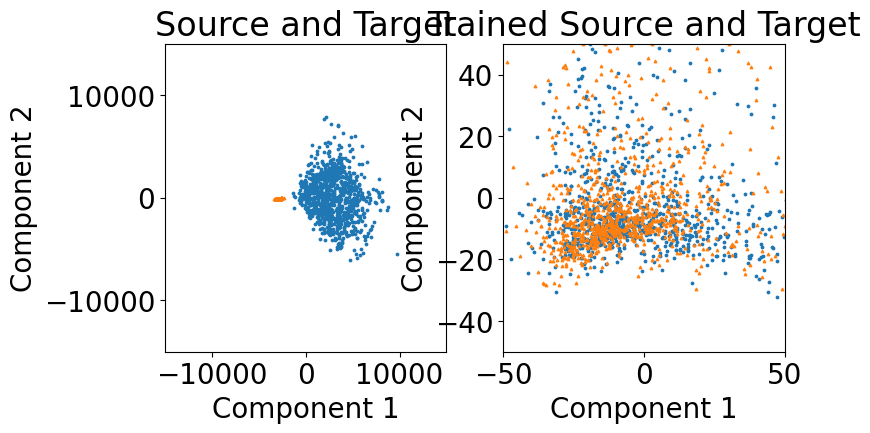

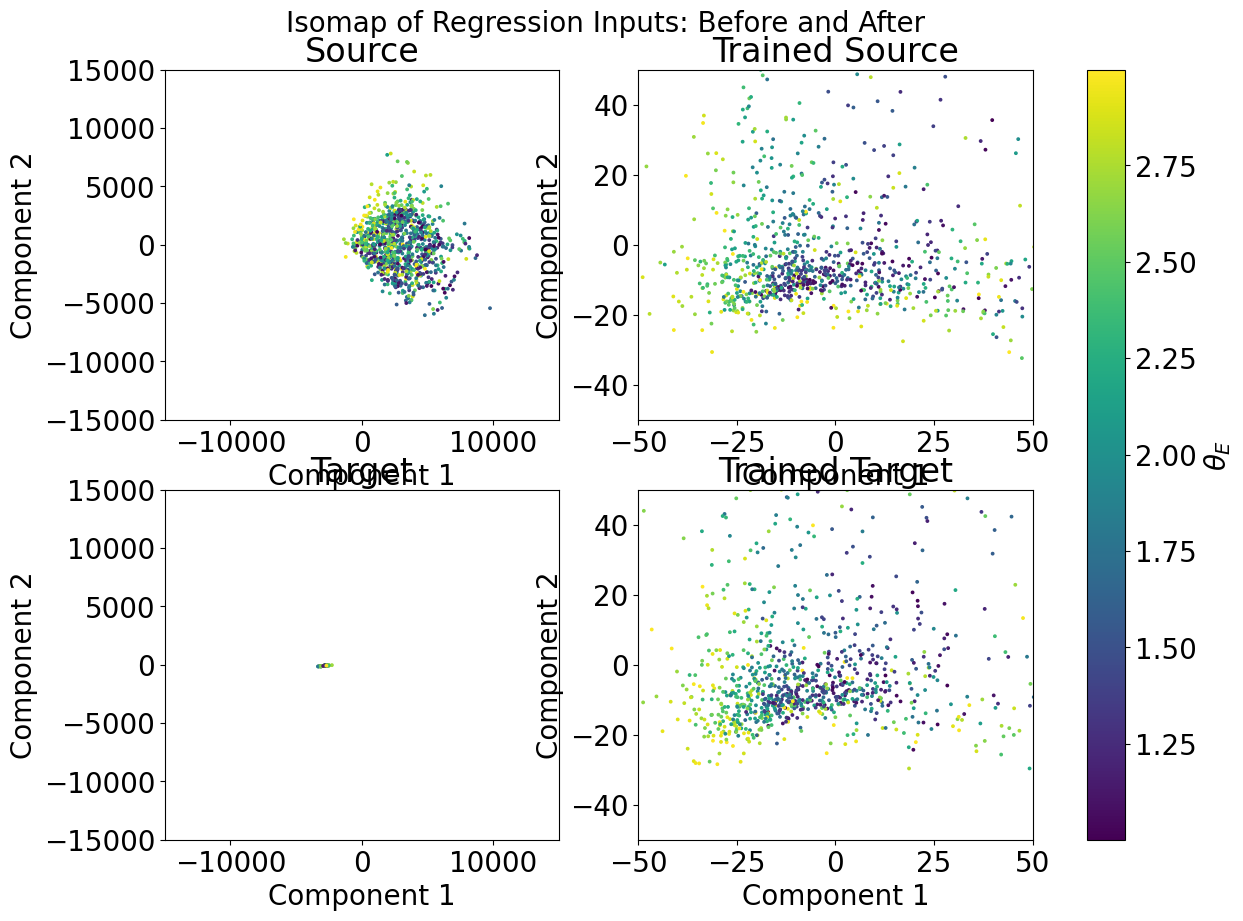

Saving Model... Done.
Saving Model MVE... Done.

Epoch 75: 12.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1449
	Train Regression Loss: : 0.0649
	Train Mve Loss: : 1.7565
	Train R2 Score: : 0.7948
 Validation Statistics:
	Val Source Regression Loss: : 0.0380
	Val Target Regression Loss: : 0.0410
	Val Source R2 Score: : 0.8674
	Val Target R2 Score: : 0.8701
	Val Source Mve Loss: : 1.1031
	Val Target Mve Loss: : 4.3134
Saving Model... Done.

Epoch 76: 14.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1475
	Train Regression Loss: : 0.0416
	Train Mve Loss: : 1.3288
	Train R2 Score: : 0.8687
 Validation Statistics:
	Val Source Regression Loss: : 0.0385
	Val Target Regression Loss: : 0.0437
	Val Source R2 Score: : 0.8784
	Val Target R2 Score: : 0.8599
	Val Source Mve Loss: : 0.0317
	Val Target Mve Loss: : 0.0280
Saving Model MVE... Done.

Epoch 77: 15.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


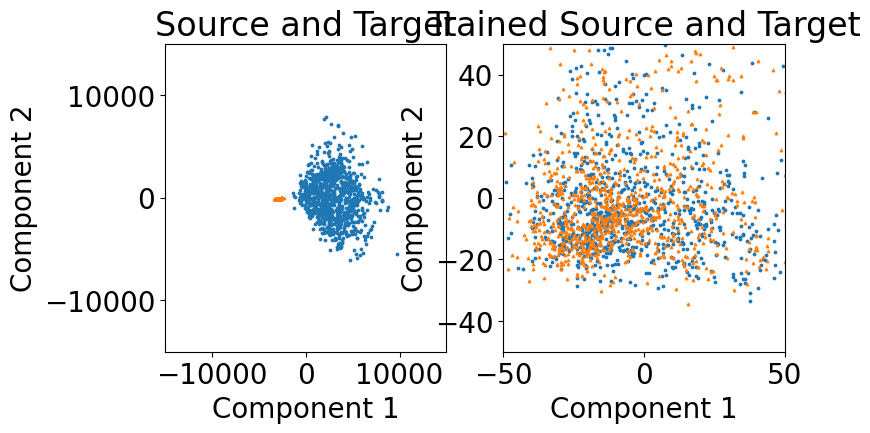

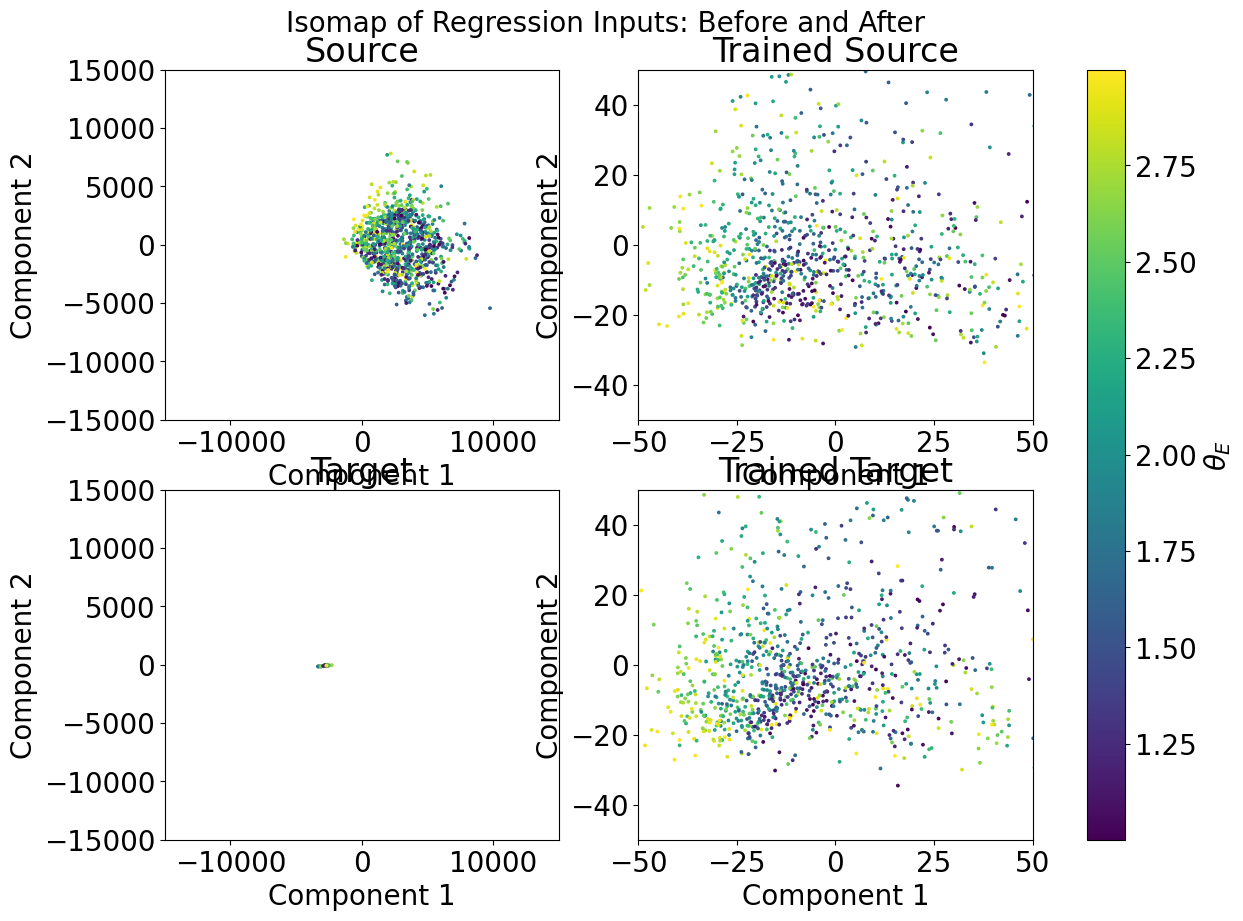

Saving Model... Done.
Saving Model MVE... Done.

Epoch 80: 12.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1476
	Train Regression Loss: : 0.0269
	Train Mve Loss: : 3.8306
	Train R2 Score: : 0.9150
 Validation Statistics:
	Val Source Regression Loss: : 0.0242
	Val Target Regression Loss: : 0.0302
	Val Source R2 Score: : 0.9237
	Val Target R2 Score: : 0.9033
	Val Source Mve Loss: : 1.5959
	Val Target Mve Loss: : 4.3129

Epoch 81: 13.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1462
	Train Regression Loss: : 0.0399
	Train Mve Loss: : 1.1353
	Train R2 Score: : 0.8733
 Validation Statistics:
	Val Source Regression Loss: : 0.0750
	Val Target Regression Loss: : 0.0701
	Val Source R2 Score: : 0.7651
	Val Target R2 Score: : 0.7767
	Val Source Mve Loss: : -0.1373
	Val Target Mve Loss: : 0.0176
Saving Model MVE... Done.

Epoch 82: 12.89s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1473
	Train Regressio

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


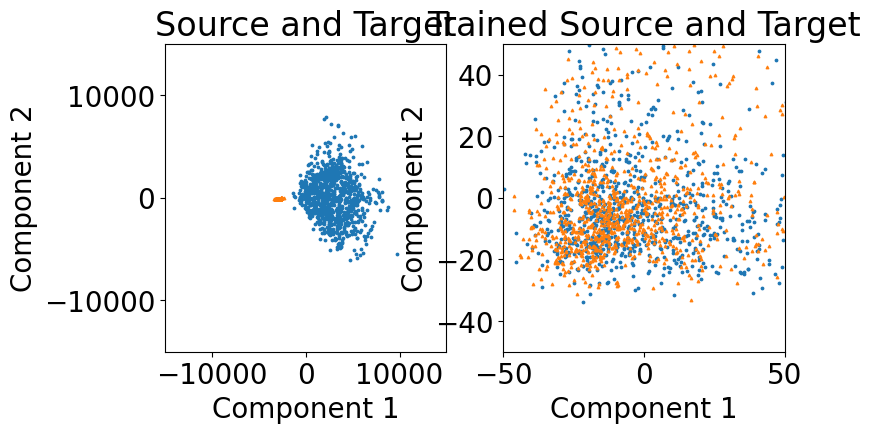

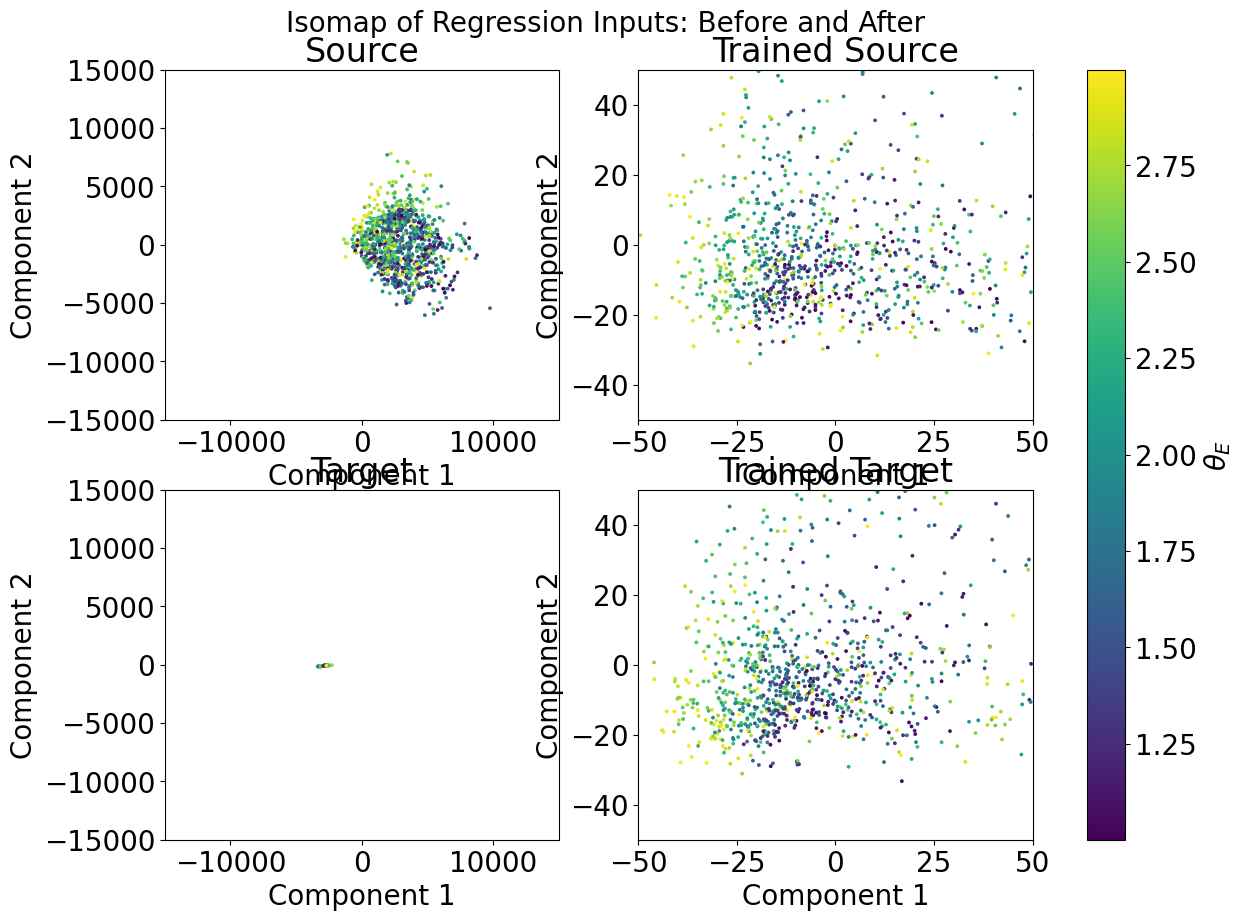

Saving Model MVE... Done.

Epoch 85: 13.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1463
	Train Regression Loss: : 0.0488
	Train Mve Loss: : 1.3755
	Train R2 Score: : 0.8454
 Validation Statistics:
	Val Source Regression Loss: : 0.0185
	Val Target Regression Loss: : 0.0229
	Val Source R2 Score: : 0.9431
	Val Target R2 Score: : 0.9273
	Val Source Mve Loss: : 6.4792
	Val Target Mve Loss: : 11.1555
Saving Model... Done.

Epoch 86: 11.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1469
	Train Regression Loss: : 0.0187
	Train Mve Loss: : 0.8579
	Train R2 Score: : 0.9410
 Validation Statistics:
	Val Source Regression Loss: : 0.0192
	Val Target Regression Loss: : 0.0239
	Val Source R2 Score: : 0.9407
	Val Target R2 Score: : 0.9240
	Val Source Mve Loss: : 3.0620
	Val Target Mve Loss: : 4.7657

Epoch 87: 11.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1475
	Train Regression Loss: : 0.0232
	Train Mv

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


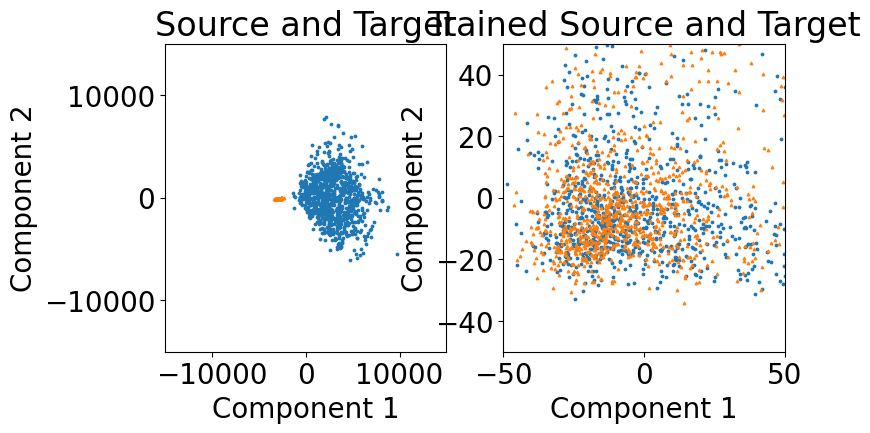

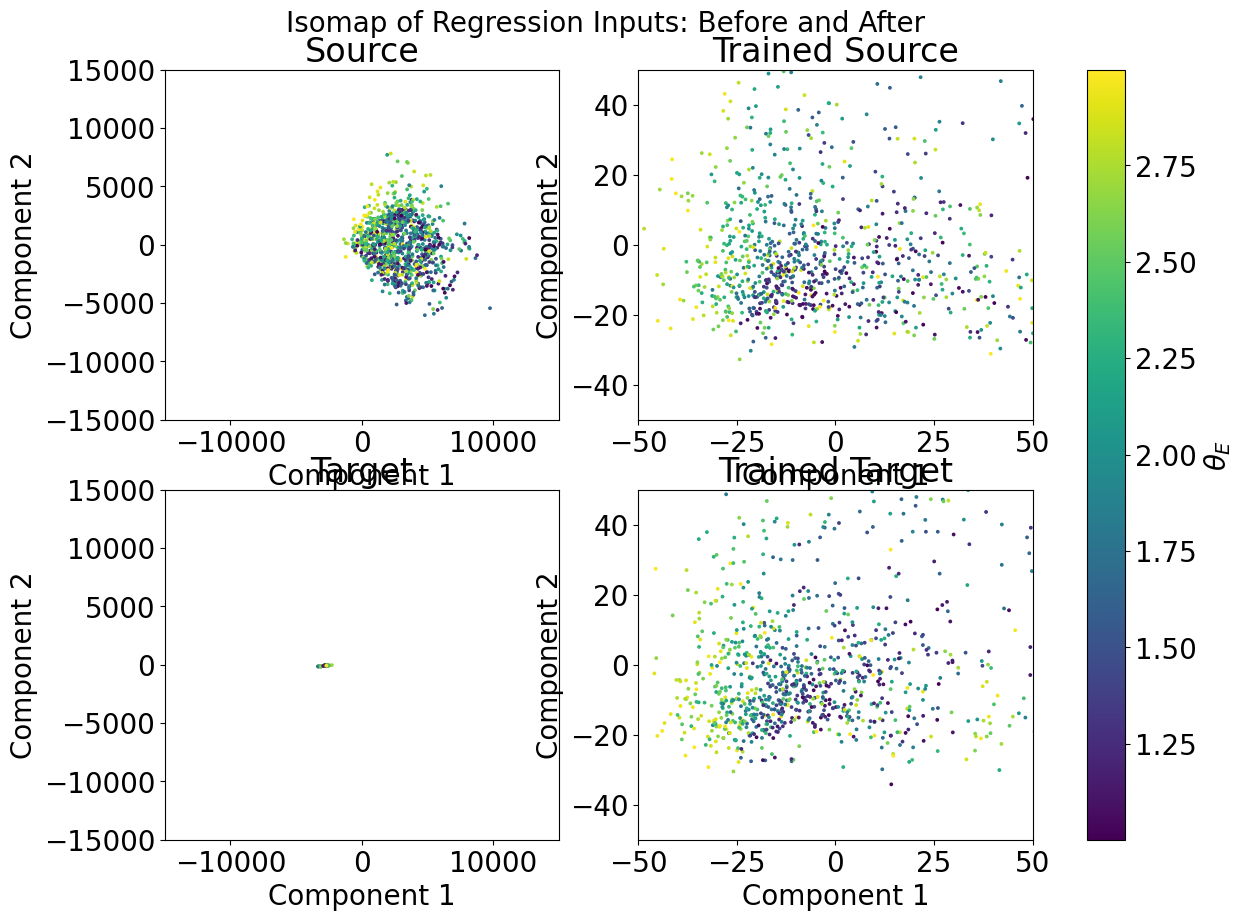


Epoch 90: 13.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1464
	Train Regression Loss: : 0.0277
	Train Mve Loss: : 0.7649
	Train R2 Score: : 0.9128
 Validation Statistics:
	Val Source Regression Loss: : 0.0324
	Val Target Regression Loss: : 0.0360
	Val Source R2 Score: : 0.8979
	Val Target R2 Score: : 0.8846
	Val Source Mve Loss: : 1.9109
	Val Target Mve Loss: : 0.5660
Saving Model MVE... Done.

Epoch 91: 13.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1475
	Train Regression Loss: : 0.0579
	Train Mve Loss: : 0.8451
	Train R2 Score: : 0.8164
 Validation Statistics:
	Val Source Regression Loss: : 0.0242
	Val Target Regression Loss: : 0.0291
	Val Source R2 Score: : 0.9240
	Val Target R2 Score: : 0.9054
	Val Source Mve Loss: : 1.2869
	Val Target Mve Loss: : 0.5745
Saving Model MVE... Done.

Epoch 92: 12.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1468
	Train Regression Loss: : 0.0323
	Train

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


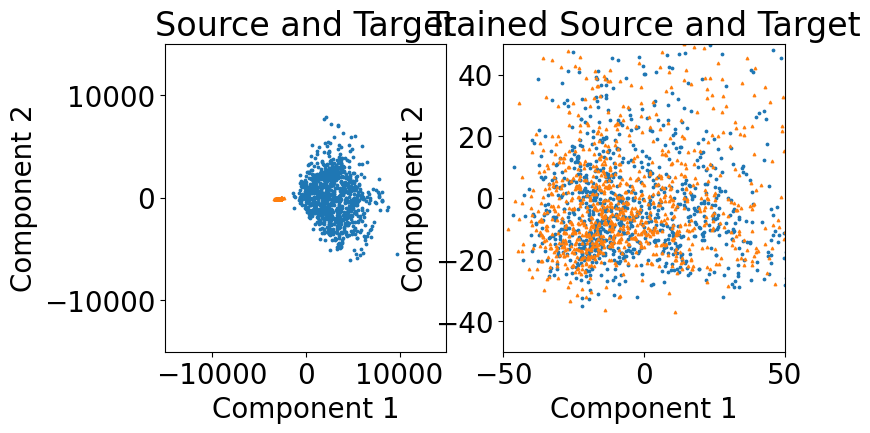

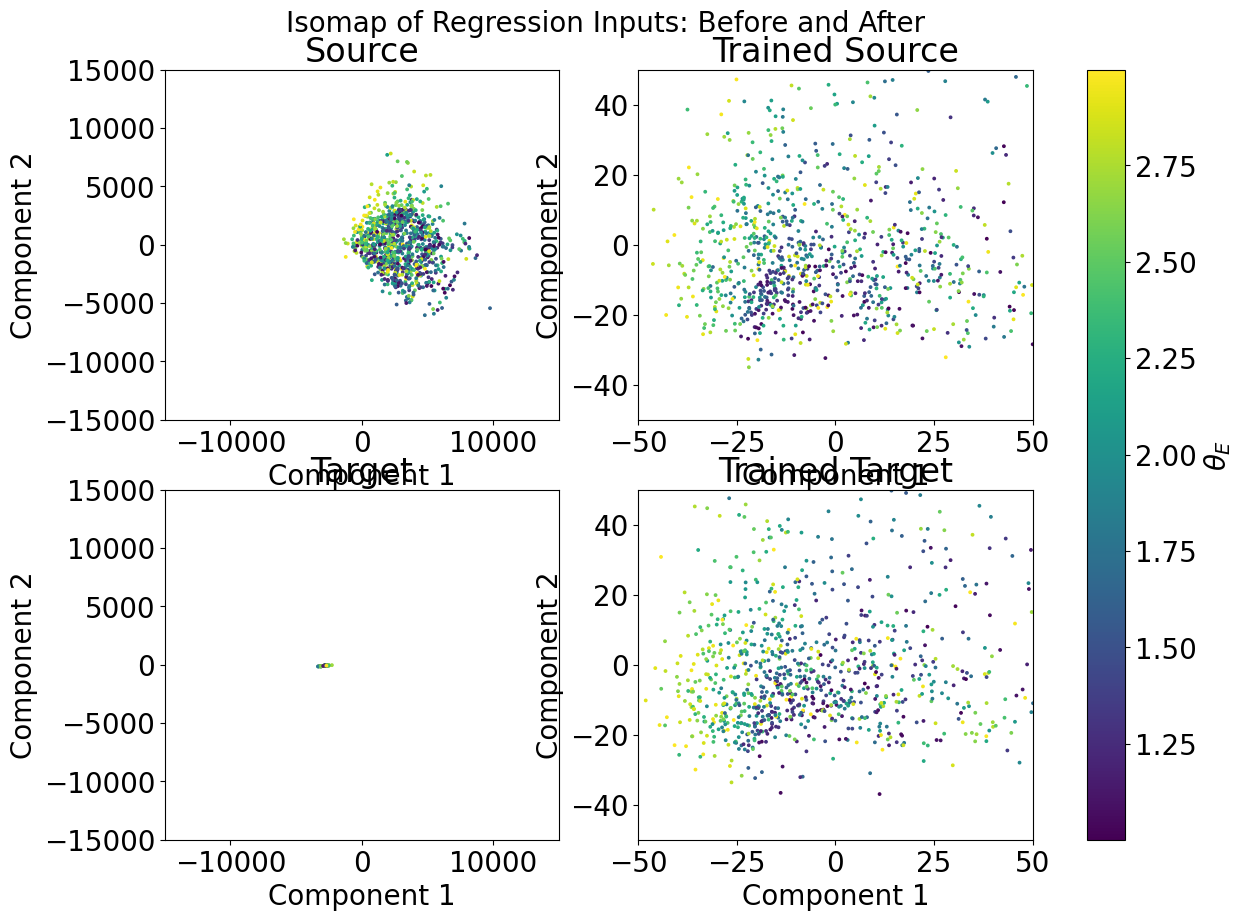


Epoch 95: 12.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1479
	Train Regression Loss: : 0.0227
	Train Mve Loss: : 1.7949
	Train R2 Score: : 0.9284
 Validation Statistics:
	Val Source Regression Loss: : 0.0196
	Val Target Regression Loss: : 0.0239
	Val Source R2 Score: : 0.9380
	Val Target R2 Score: : 0.9241
	Val Source Mve Loss: : 2.6234
	Val Target Mve Loss: : 2.6044

Epoch 96: 12.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1492
	Train Regression Loss: : 0.0238
	Train Mve Loss: : 0.2773
	Train R2 Score: : 0.9248
 Validation Statistics:
	Val Source Regression Loss: : 0.0203
	Val Target Regression Loss: : 0.0241
	Val Source R2 Score: : 0.9366
	Val Target R2 Score: : 0.9231
	Val Source Mve Loss: : 0.2247
	Val Target Mve Loss: : 0.2107
Saving Model MVE... Done.

Epoch 97: 12.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1475
	Train Regression Loss: : 0.0207
	Train Mve Loss: : 0.2914
	Train

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


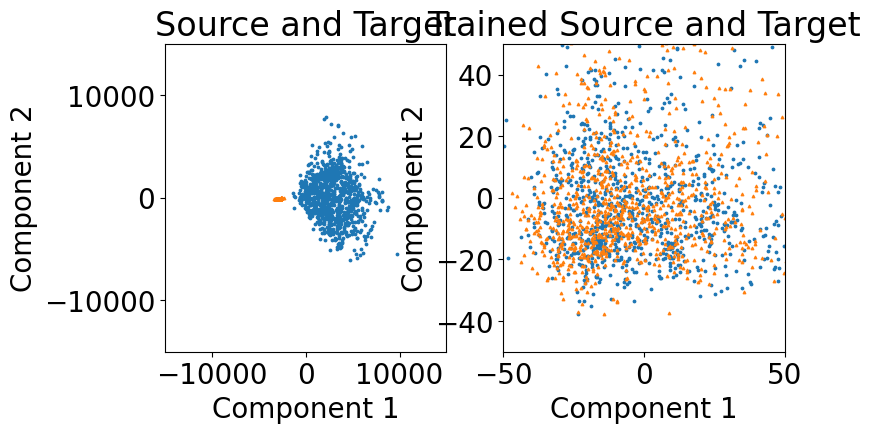

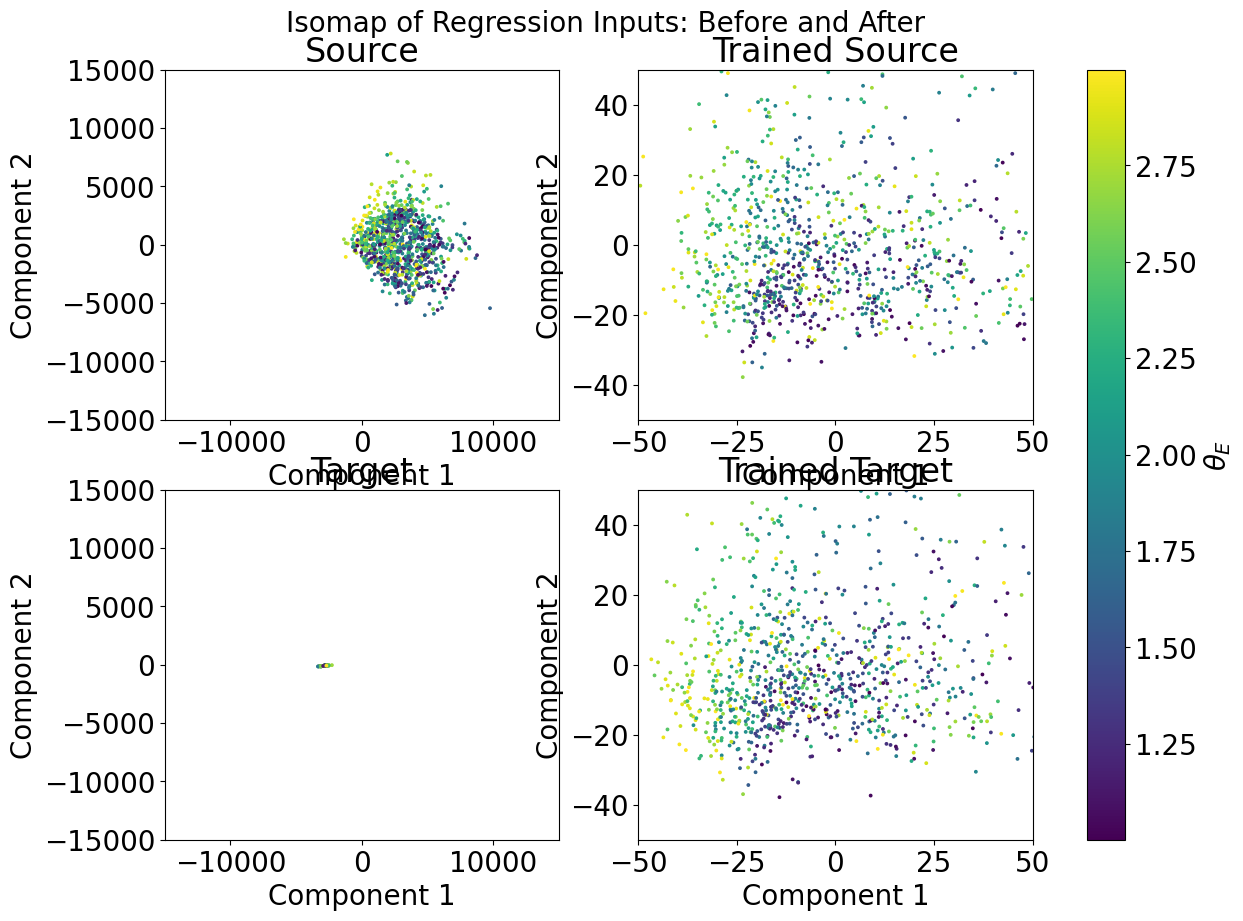


Epoch 100: 12.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1506
	Train Regression Loss: : 0.0541
	Train Mve Loss: : 0.8014
	Train R2 Score: : 0.8290
 Validation Statistics:
	Val Source Regression Loss: : 0.0554
	Val Target Regression Loss: : 0.0592
	Val Source R2 Score: : 0.8264
	Val Target R2 Score: : 0.8116
	Val Source Mve Loss: : 0.2807
	Val Target Mve Loss: : 0.2746
Saving Model MVE... Done.

Epoch 101: 12.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1510
	Train Regression Loss: : 0.0364
	Train Mve Loss: : 0.1646
	Train R2 Score: : 0.8851
 Validation Statistics:
	Val Source Regression Loss: : 0.0263
	Val Target Regression Loss: : 0.0303
	Val Source R2 Score: : 0.9175
	Val Target R2 Score: : 0.9041
	Val Source Mve Loss: : 0.1147
	Val Target Mve Loss: : 0.2087
Saving Model MVE... Done.

Epoch 102: 13.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1487
	Train Regression Loss: : 0.0242
	Tr

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


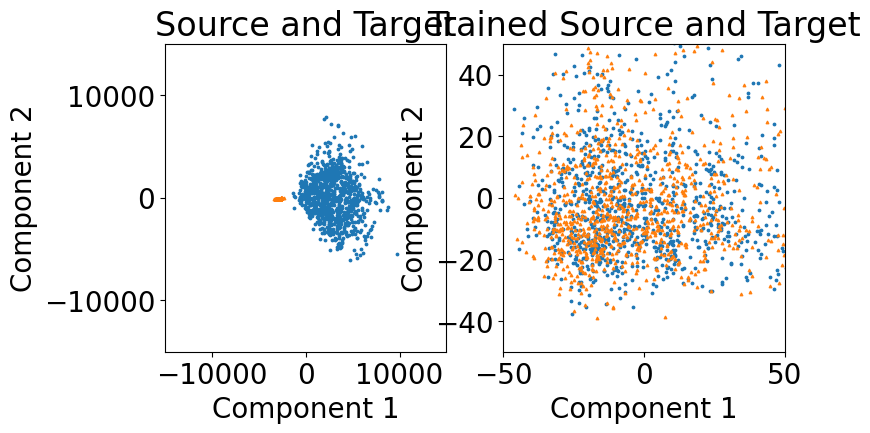

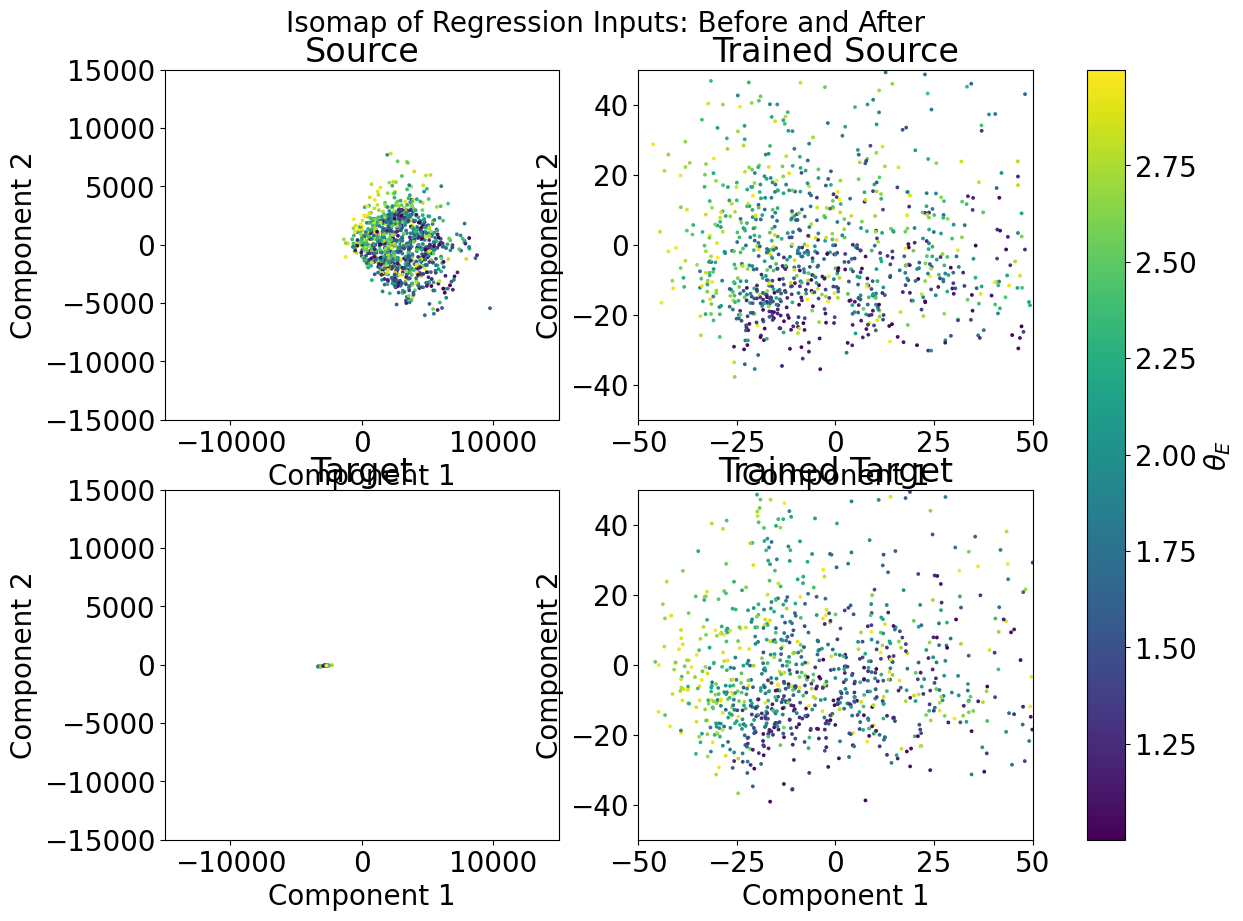


Epoch 105: 12.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1488
	Train Regression Loss: : 0.0236
	Train Mve Loss: : 0.3304
	Train R2 Score: : 0.9256
 Validation Statistics:
	Val Source Regression Loss: : 0.0220
	Val Target Regression Loss: : 0.0251
	Val Source R2 Score: : 0.9304
	Val Target R2 Score: : 0.9193
	Val Source Mve Loss: : 0.1962
	Val Target Mve Loss: : 0.1986
Saving Model MVE... Done.

Epoch 106: 13.57s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1504
	Train Regression Loss: : 0.0212
	Train Mve Loss: : 0.1587
	Train R2 Score: : 0.9331
 Validation Statistics:
	Val Source Regression Loss: : 0.0293
	Val Target Regression Loss: : 0.0315
	Val Source R2 Score: : 0.9086
	Val Target R2 Score: : 0.9004
	Val Source Mve Loss: : 0.1412
	Val Target Mve Loss: : 0.1008
Saving Model MVE... Done.

Epoch 107: 14.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1497
	Train Regression Loss: : 0.0223
	Tr

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


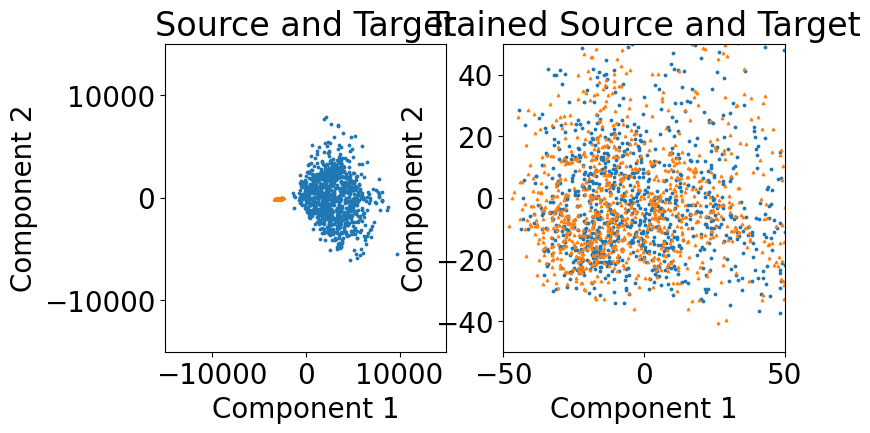

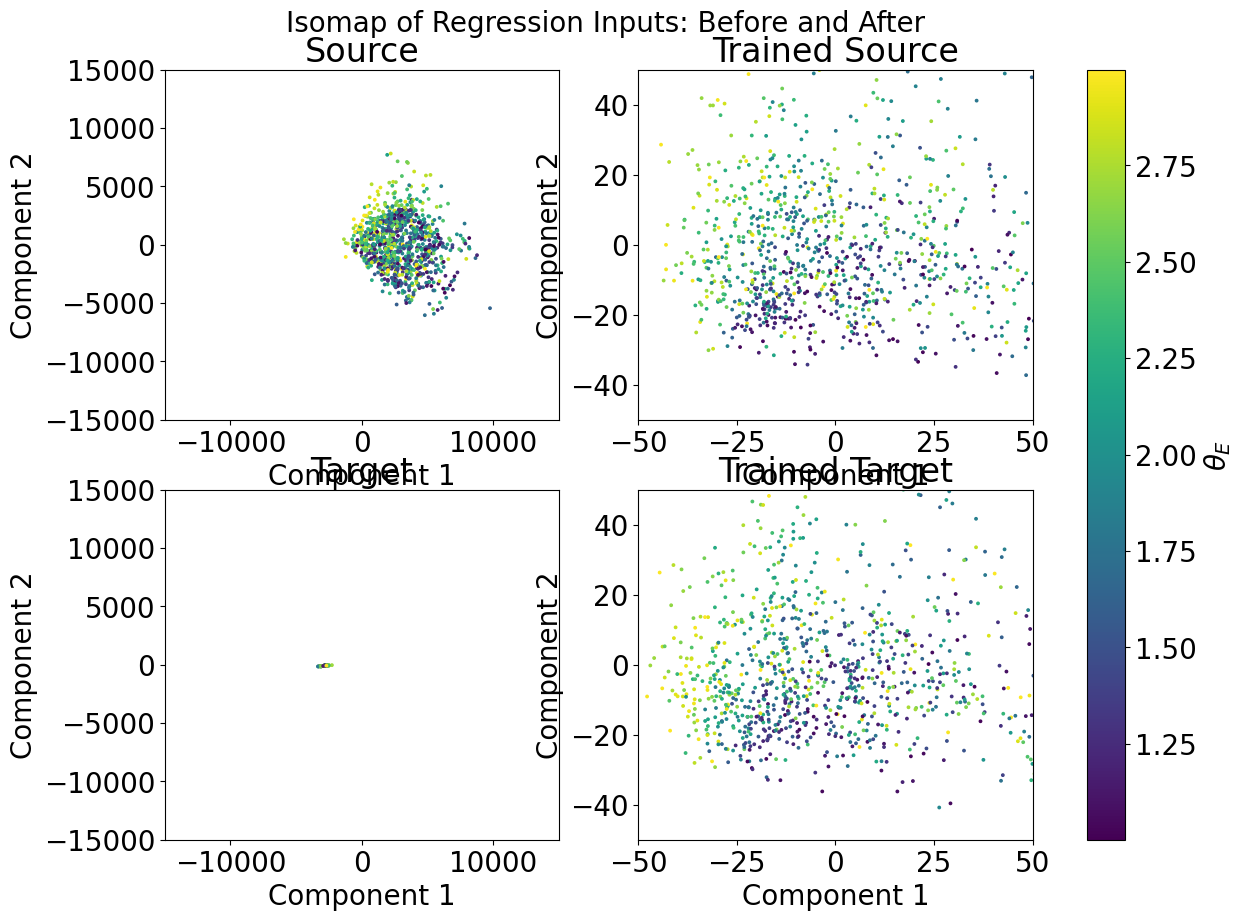


Epoch 110: 14.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1500
	Train Regression Loss: : 0.0224
	Train Mve Loss: : 2.9416
	Train R2 Score: : 0.9294
 Validation Statistics:
	Val Source Regression Loss: : 0.0195
	Val Target Regression Loss: : 0.0221
	Val Source R2 Score: : 0.9382
	Val Target R2 Score: : 0.9292
	Val Source Mve Loss: : 8.6640
	Val Target Mve Loss: : 9.9999

Epoch 111: 12.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1491
	Train Regression Loss: : 0.0173
	Train Mve Loss: : 4.6341
	Train R2 Score: : 0.9454
 Validation Statistics:
	Val Source Regression Loss: : 0.0207
	Val Target Regression Loss: : 0.0233
	Val Source R2 Score: : 0.9351
	Val Target R2 Score: : 0.9256
	Val Source Mve Loss: : 10.5210
	Val Target Mve Loss: : 10.9060

Epoch 112: 13.05s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1491
	Train Regression Loss: : 0.0167
	Train Mve Loss: : 3.6376
	Train R2 Score: : 0.9473
 

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


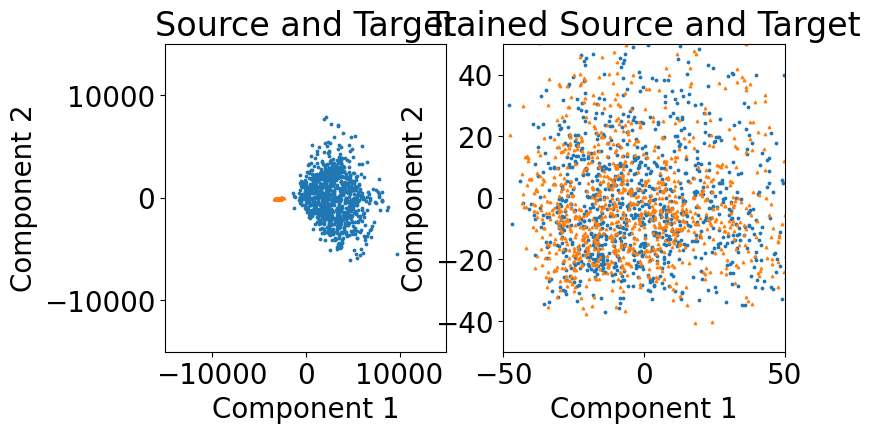

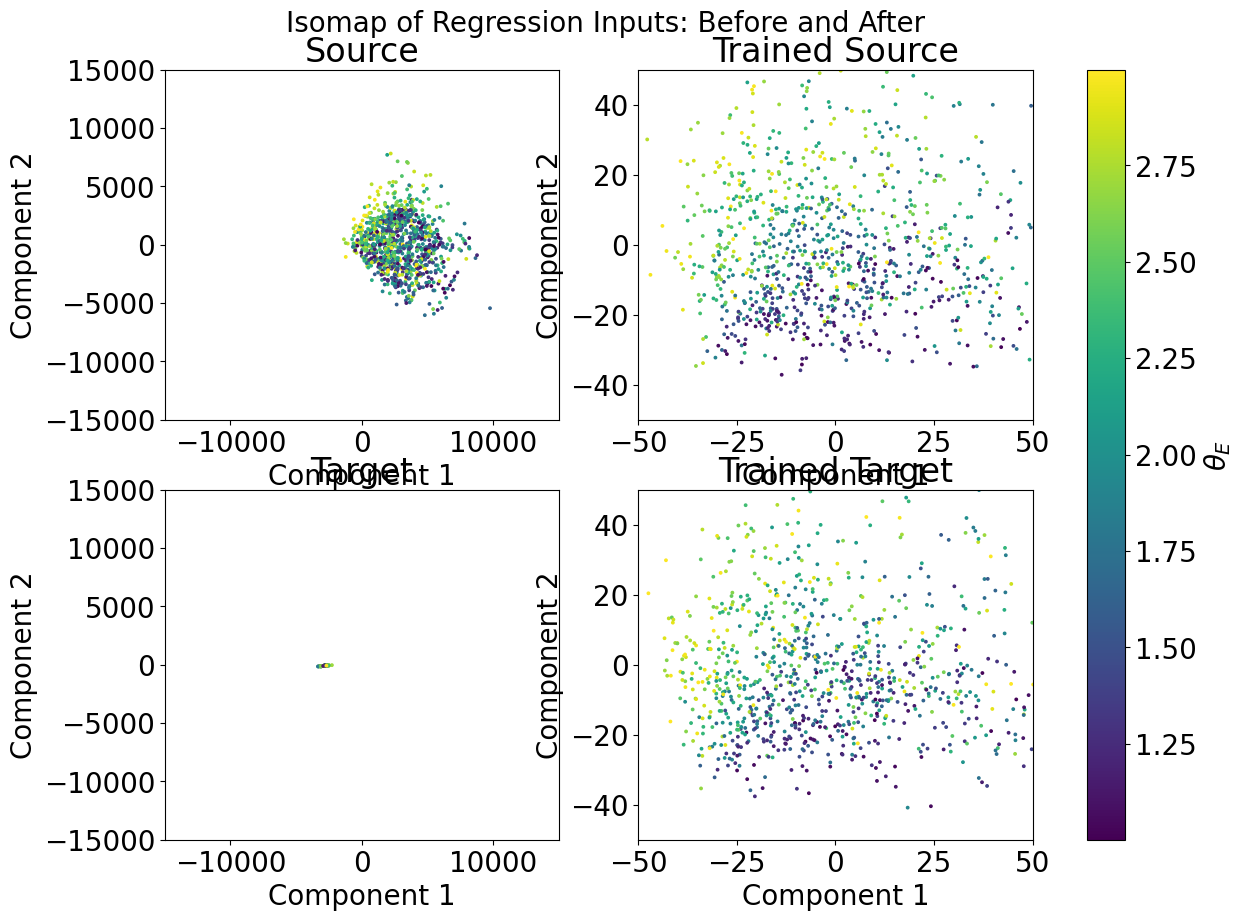


Epoch 115: 13.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1524
	Train Regression Loss: : 0.0190
	Train Mve Loss: : 5.5037
	Train R2 Score: : 0.9402
 Validation Statistics:
	Val Source Regression Loss: : 0.0182
	Val Target Regression Loss: : 0.0215
	Val Source R2 Score: : 0.9421
	Val Target R2 Score: : 0.9320
	Val Source Mve Loss: : 4.6154
	Val Target Mve Loss: : 7.3111

Epoch 116: 12.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1512
	Train Regression Loss: : 0.0164
	Train Mve Loss: : 4.0854
	Train R2 Score: : 0.9483
 Validation Statistics:
	Val Source Regression Loss: : 0.0173
	Val Target Regression Loss: : 0.0209
	Val Source R2 Score: : 0.9451
	Val Target R2 Score: : 0.9328
	Val Source Mve Loss: : 1.3918
	Val Target Mve Loss: : 2.0289

Epoch 117: 12.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1508
	Train Regression Loss: : 0.0155
	Train Mve Loss: : 1.3422
	Train R2 Score: : 0.9512
 Va

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


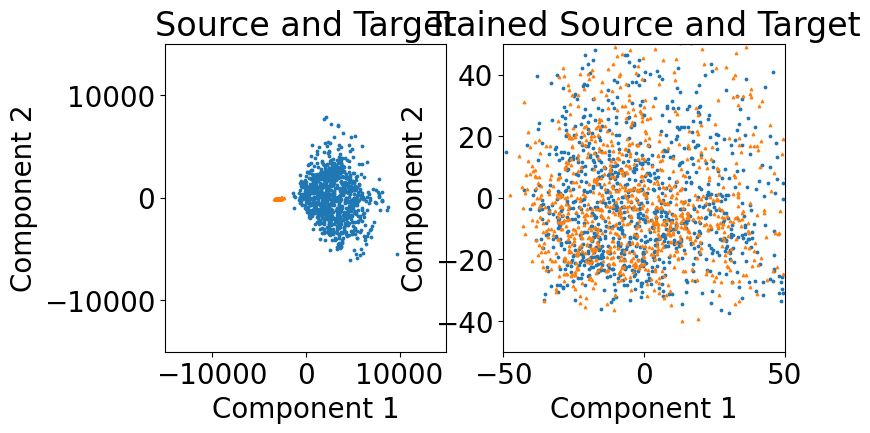

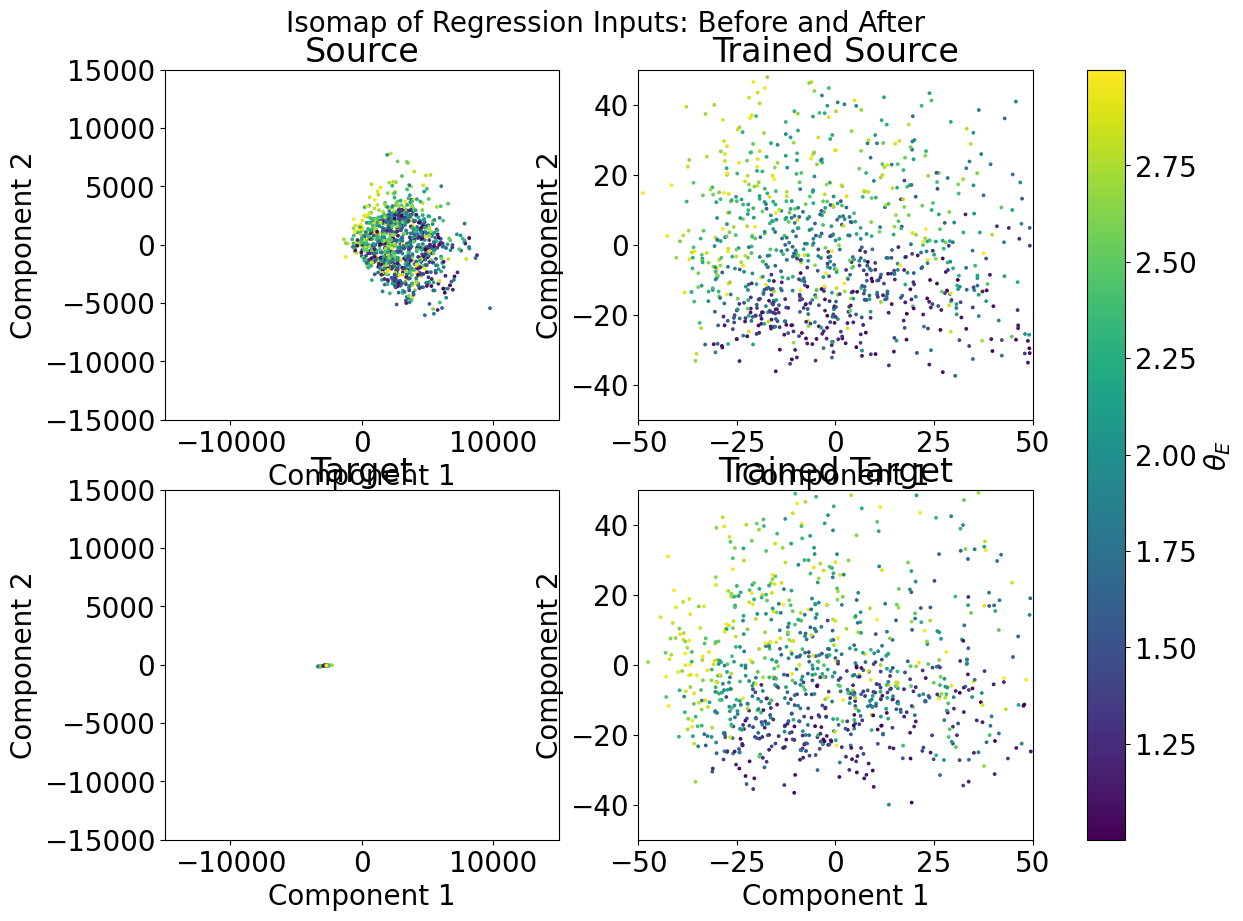

Saving Model MVE... Done.

Epoch 120: 15.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1526
	Train Regression Loss: : 0.0197
	Train Mve Loss: : 1.5911
	Train R2 Score: : 0.9376
 Validation Statistics:
	Val Source Regression Loss: : 0.0196
	Val Target Regression Loss: : 0.0226
	Val Source R2 Score: : 0.9390
	Val Target R2 Score: : 0.9267
	Val Source Mve Loss: : -0.1116
	Val Target Mve Loss: : 0.3283
Saving Model MVE... Done.

Epoch 121: 22.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1513
	Train Regression Loss: : 0.0180
	Train Mve Loss: : 0.8506
	Train R2 Score: : 0.9434
 Validation Statistics:
	Val Source Regression Loss: : 0.0212
	Val Target Regression Loss: : 0.0273
	Val Source R2 Score: : 0.9329
	Val Target R2 Score: : 0.9125
	Val Source Mve Loss: : 0.0753
	Val Target Mve Loss: : 0.1158
Saving Model MVE... Done.

Epoch 122: 17.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1520
	Train Re

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


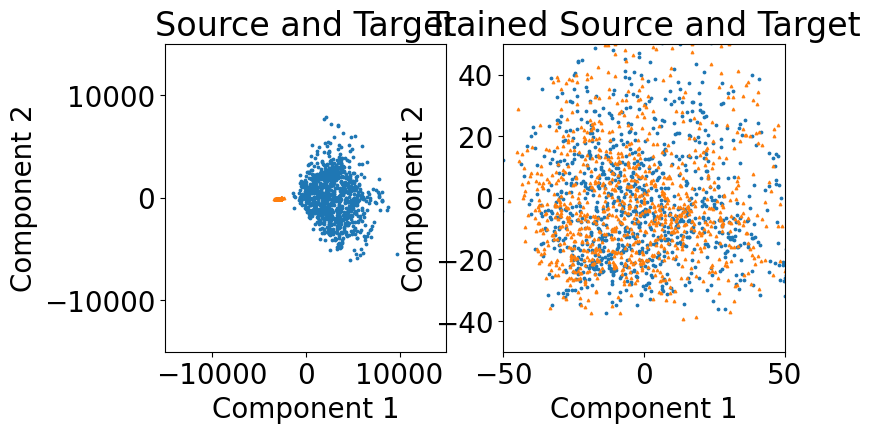

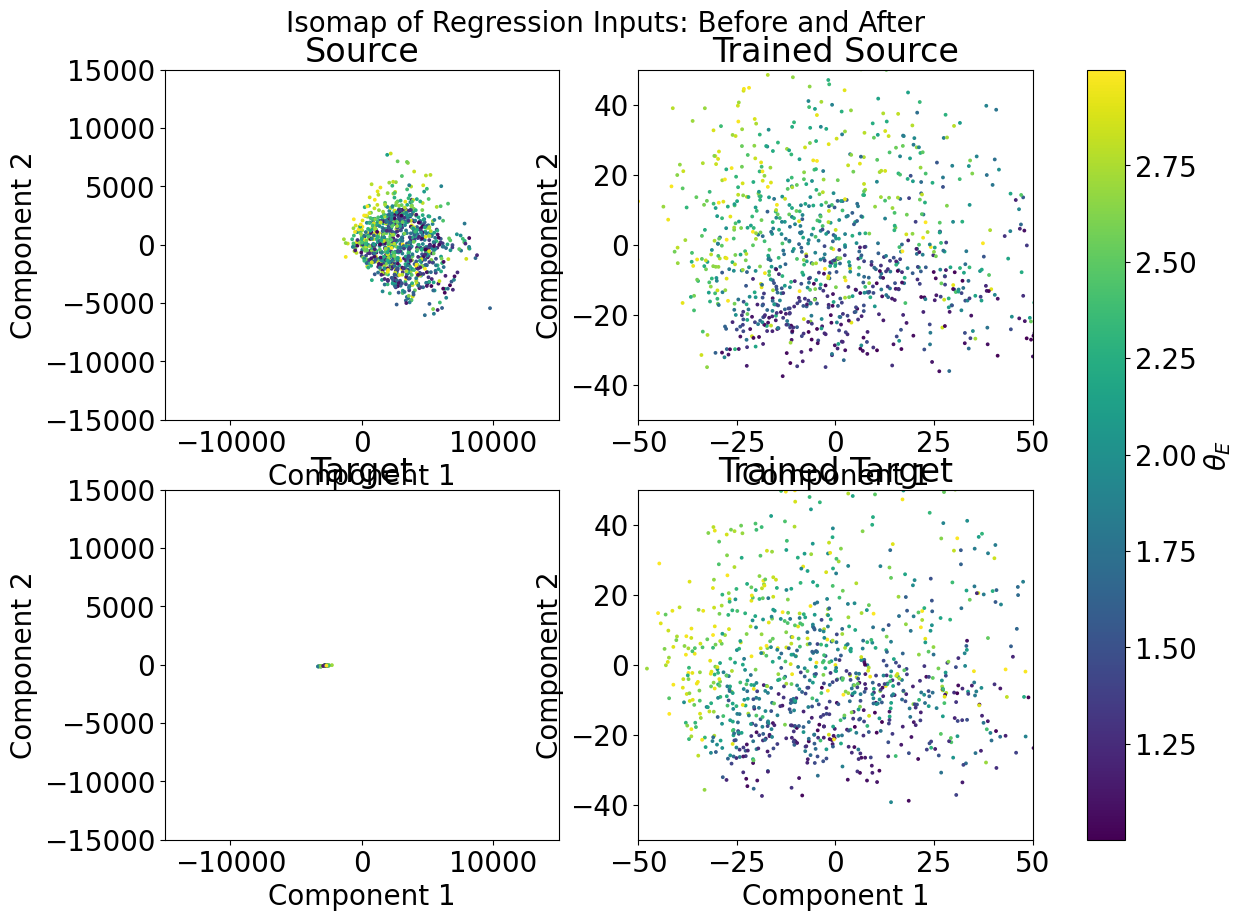


Epoch 125: 13.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1534
	Train Regression Loss: : 0.0163
	Train Mve Loss: : 1.8279
	Train R2 Score: : 0.9485
 Validation Statistics:
	Val Source Regression Loss: : 0.0176
	Val Target Regression Loss: : 0.0209
	Val Source R2 Score: : 0.9445
	Val Target R2 Score: : 0.9325
	Val Source Mve Loss: : 0.2821
	Val Target Mve Loss: : 0.4690
Saving Model MVE... Done.

Epoch 126: 12.44s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1527
	Train Regression Loss: : 0.0157
	Train Mve Loss: : 3.1408
	Train R2 Score: : 0.9504
 Validation Statistics:
	Val Source Regression Loss: : 0.0138
	Val Target Regression Loss: : 0.0175
	Val Source R2 Score: : 0.9563
	Val Target R2 Score: : 0.9431
	Val Source Mve Loss: : 0.6334
	Val Target Mve Loss: : 0.8927
Saving Model... Done.
Saving Model MVE... Done.

Epoch 127: 12.77s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1527
	Train Regress

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


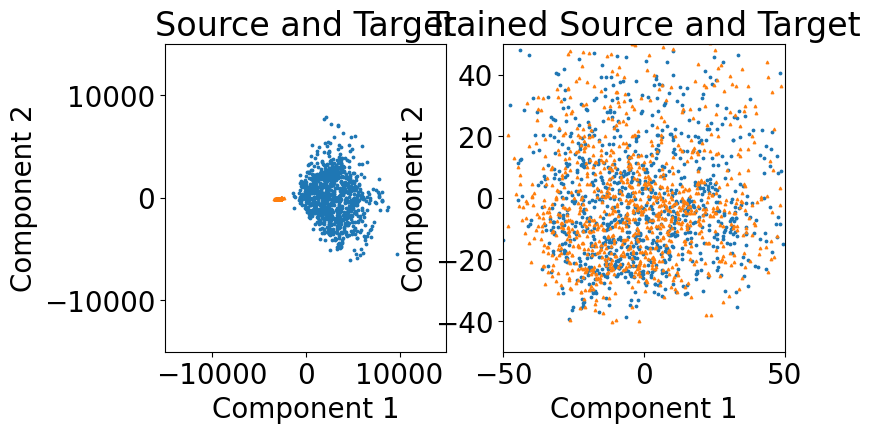

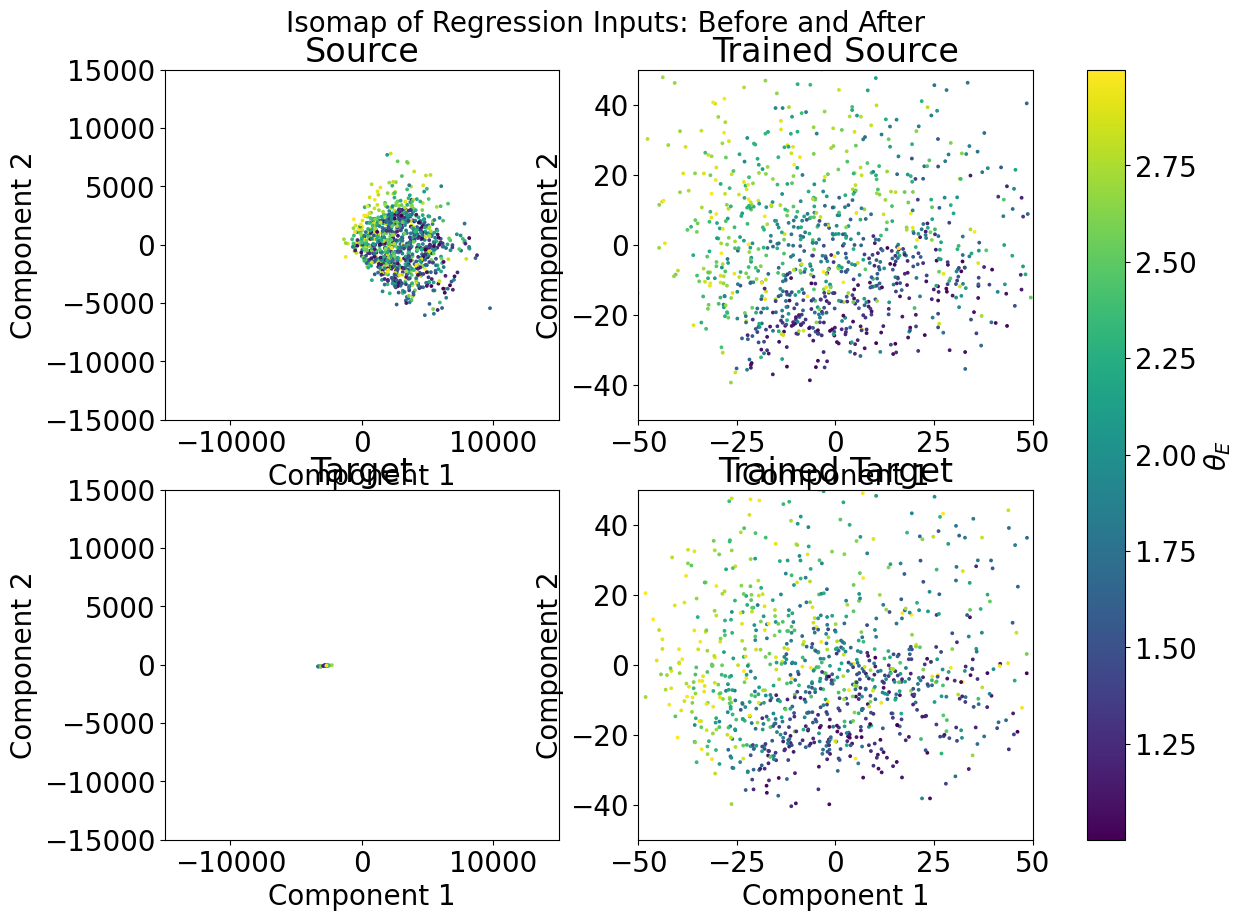


Epoch 130: 12.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1536
	Train Regression Loss: : 0.0145
	Train Mve Loss: : 3.2615
	Train R2 Score: : 0.9541
 Validation Statistics:
	Val Source Regression Loss: : 0.0137
	Val Target Regression Loss: : 0.0176
	Val Source R2 Score: : 0.9571
	Val Target R2 Score: : 0.9429
	Val Source Mve Loss: : 11.8621
	Val Target Mve Loss: : 9.7740

Epoch 131: 12.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1528
	Train Regression Loss: : 0.0139
	Train Mve Loss: : 0.4297
	Train R2 Score: : 0.9566
 Validation Statistics:
	Val Source Regression Loss: : 0.0141
	Val Target Regression Loss: : 0.0180
	Val Source R2 Score: : 0.9555
	Val Target R2 Score: : 0.9421
	Val Source Mve Loss: : 0.3521
	Val Target Mve Loss: : 0.8707
Saving Model MVE... Done.

Epoch 132: 12.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1534
	Train Regression Loss: : 0.0157
	Train Mve Loss: : 1.9123
	T

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


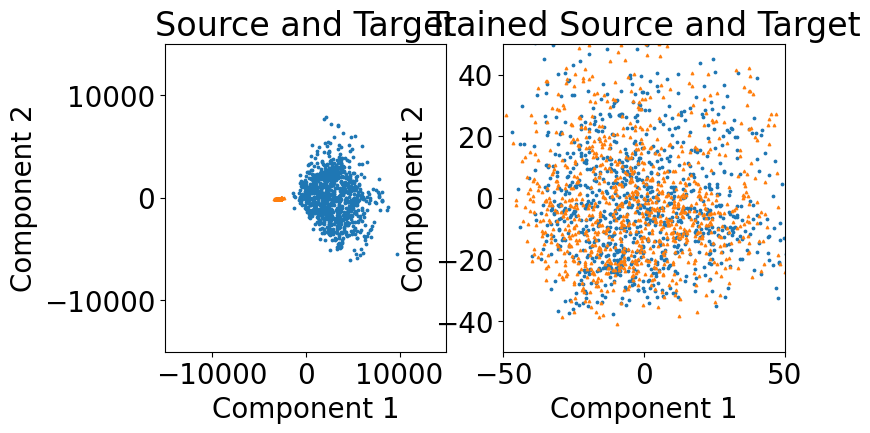

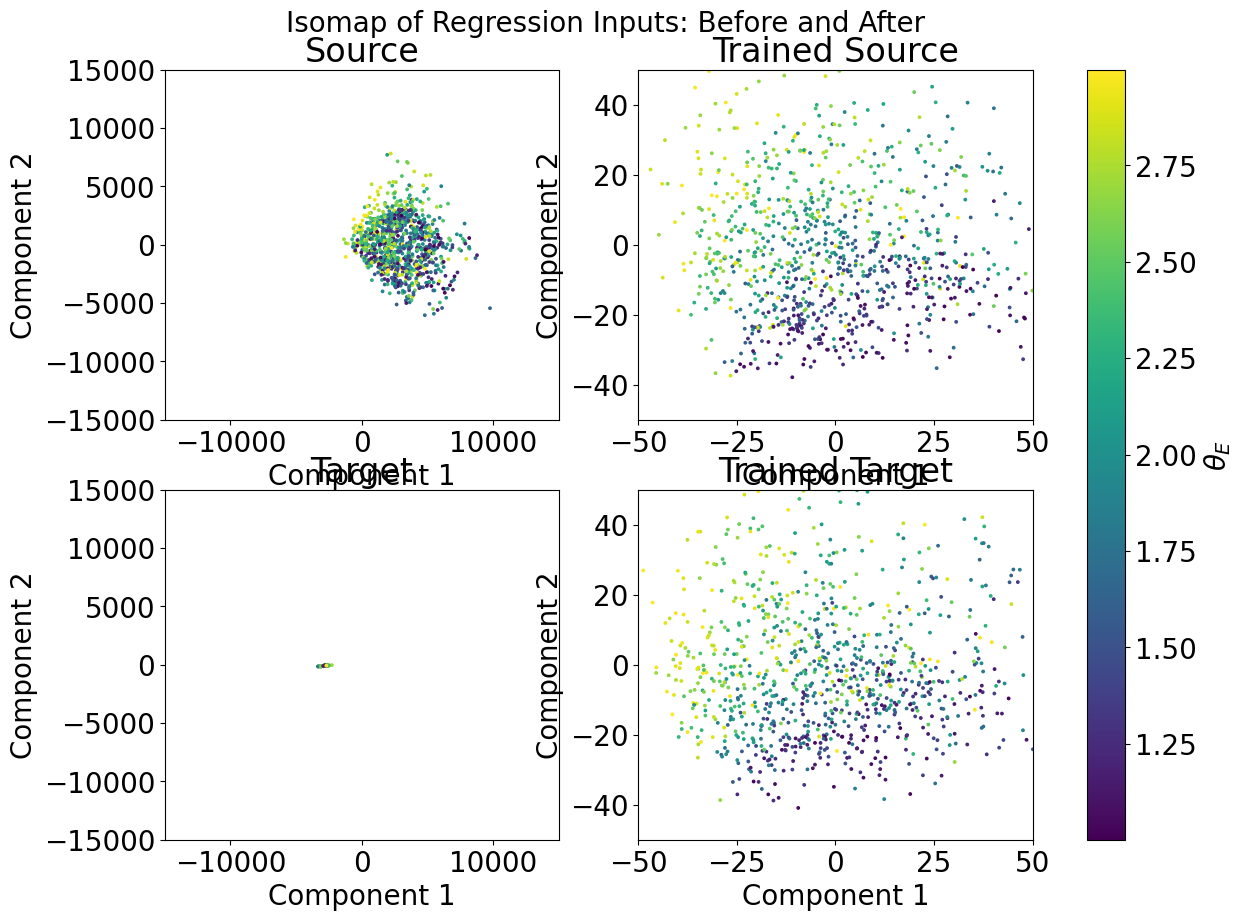


Epoch 135: 13.34s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1537
	Train Regression Loss: : 0.0132
	Train Mve Loss: : 1.2558
	Train R2 Score: : 0.9583
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.0178
	Val Source R2 Score: : 0.9562
	Val Target R2 Score: : 0.9433
	Val Source Mve Loss: : 0.1868
	Val Target Mve Loss: : 0.3509
Saving Model MVE... Done.

Epoch 136: 13.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1512
	Train Regression Loss: : 0.0151
	Train Mve Loss: : 0.2448
	Train R2 Score: : 0.9527
 Validation Statistics:
	Val Source Regression Loss: : 0.0184
	Val Target Regression Loss: : 0.0223
	Val Source R2 Score: : 0.9425
	Val Target R2 Score: : 0.9290
	Val Source Mve Loss: : 0.2228
	Val Target Mve Loss: : 0.4741
Saving Model MVE... Done.

Epoch 137: 13.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1517
	Train Regression Loss: : 0.0203
	Tr

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


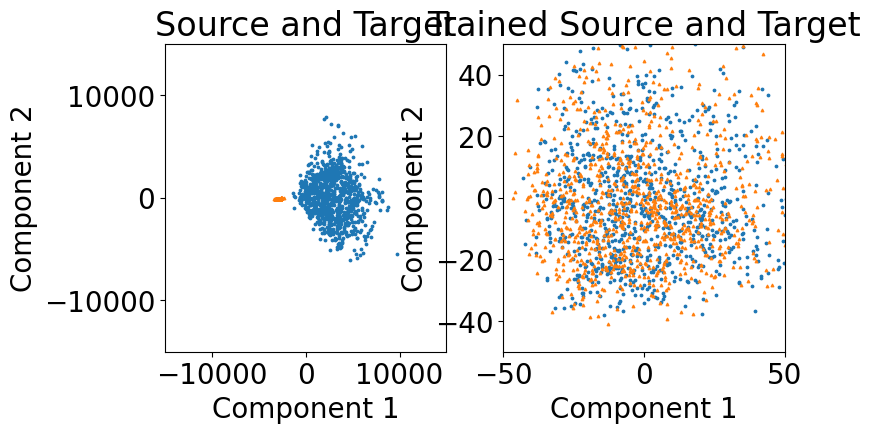

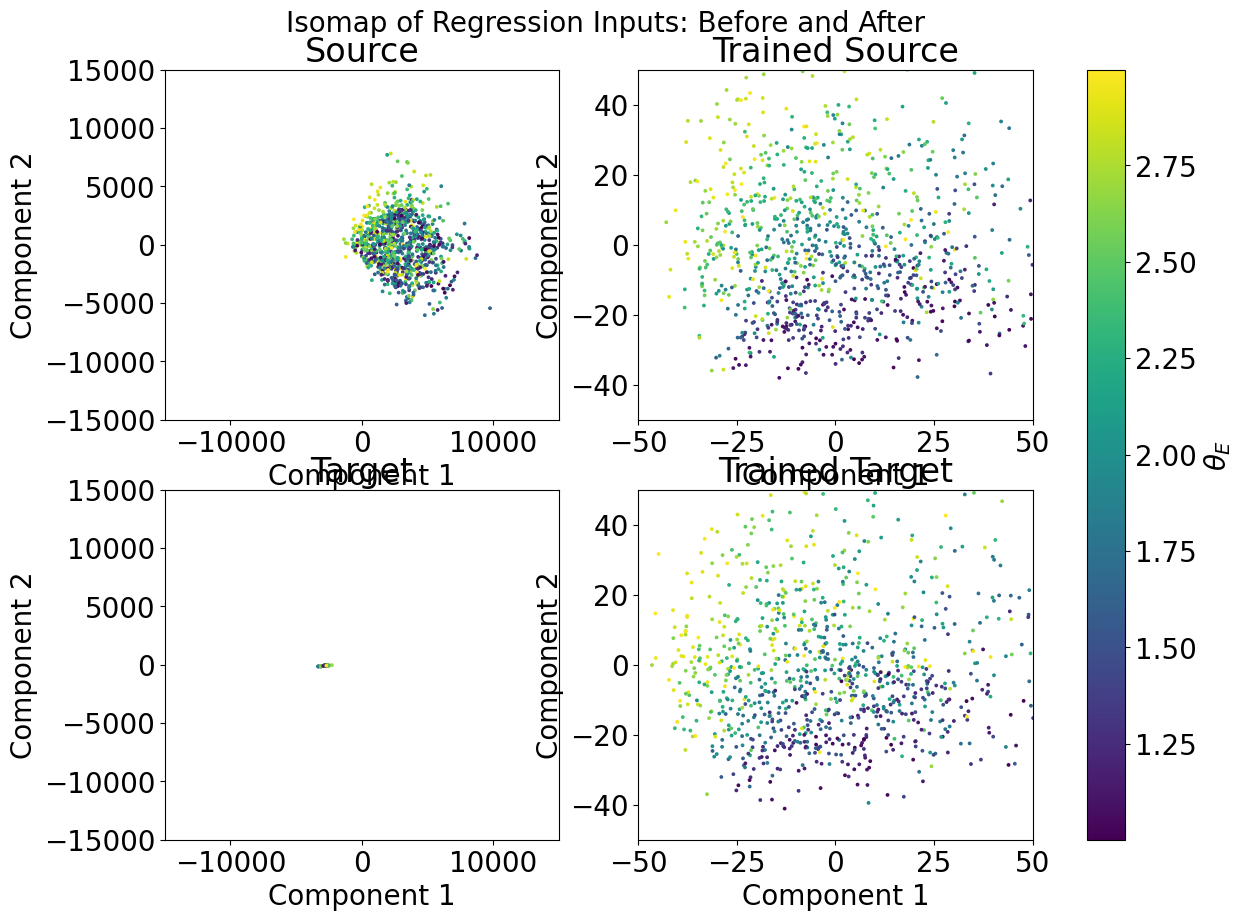

Saving Model MVE... Done.

Epoch 140: 14.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1523
	Train Regression Loss: : 0.0585
	Train Mve Loss: : 1.4867
	Train R2 Score: : 0.8134
 Validation Statistics:
	Val Source Regression Loss: : 0.0583
	Val Target Regression Loss: : 0.0597
	Val Source R2 Score: : 0.8159
	Val Target R2 Score: : 0.8087
	Val Source Mve Loss: : 0.1778
	Val Target Mve Loss: : 0.1714
Saving Model MVE... Done.

Epoch 141: 13.80s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1536
	Train Regression Loss: : 0.0184
	Train Mve Loss: : 1.0098
	Train R2 Score: : 0.9419
 Validation Statistics:
	Val Source Regression Loss: : 0.0164
	Val Target Regression Loss: : 0.0183
	Val Source R2 Score: : 0.9484
	Val Target R2 Score: : 0.9410
	Val Source Mve Loss: : 3.7633
	Val Target Mve Loss: : 3.3345

Epoch 142: 15.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1532
	Train Regression Loss: : 0.0194
	Tr

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


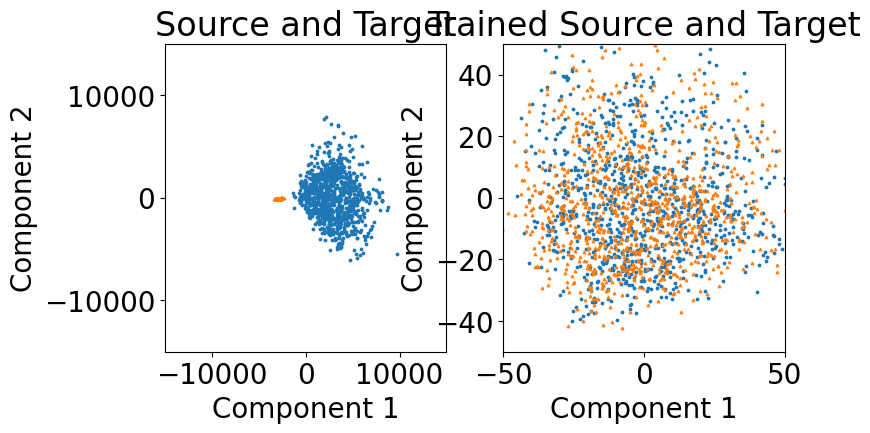

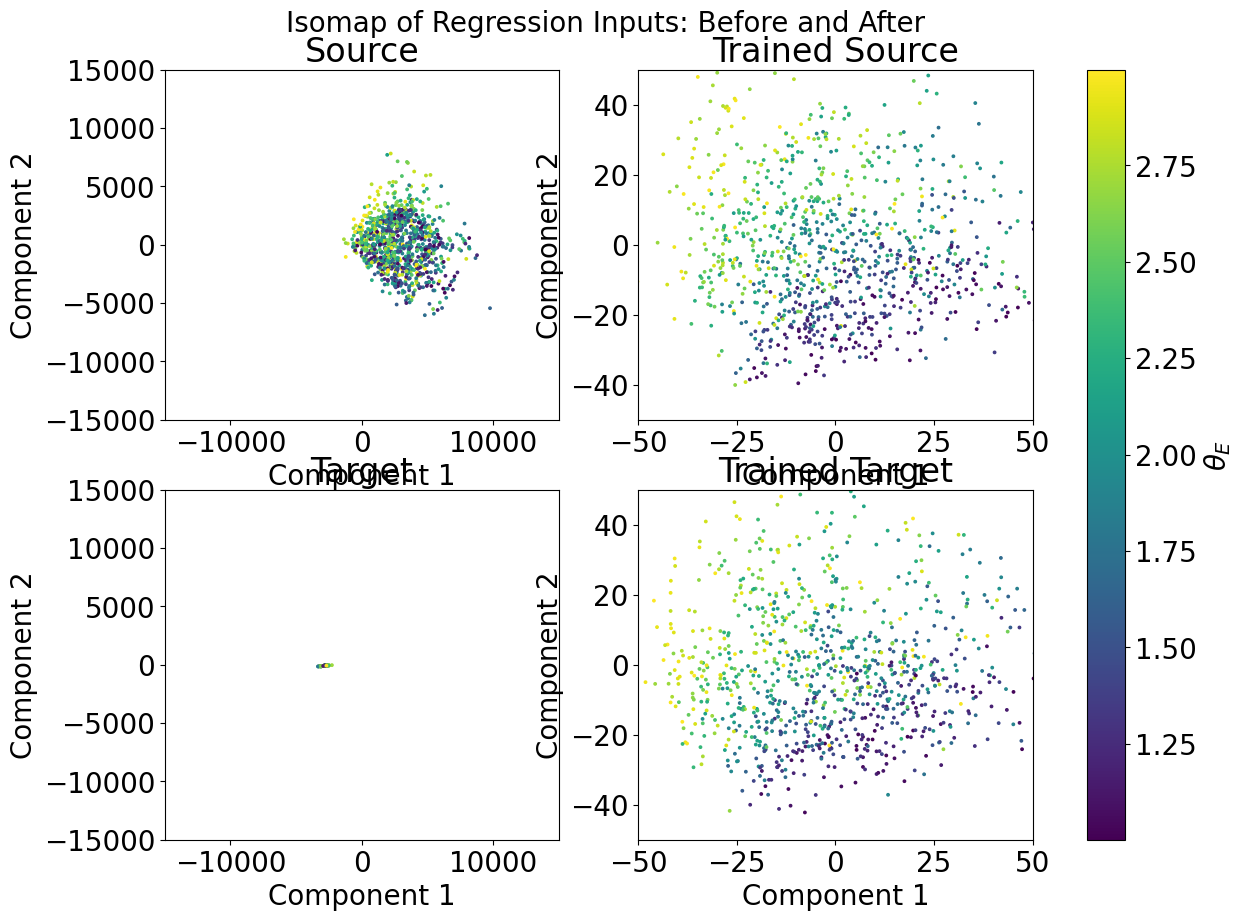


Epoch 145: 14.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1534
	Train Regression Loss: : 0.0123
	Train Mve Loss: : 1.5677
	Train R2 Score: : 0.9615
 Validation Statistics:
	Val Source Regression Loss: : 0.0140
	Val Target Regression Loss: : 0.0173
	Val Source R2 Score: : 0.9562
	Val Target R2 Score: : 0.9444
	Val Source Mve Loss: : 4.3262
	Val Target Mve Loss: : 5.1008

Epoch 146: 14.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1530
	Train Regression Loss: : 0.0115
	Train Mve Loss: : 1.2847
	Train R2 Score: : 0.9638
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.0143
	Val Source R2 Score: : 0.9641
	Val Target R2 Score: : 0.9542
	Val Source Mve Loss: : 3.9808
	Val Target Mve Loss: : 4.6253
Saving Model... Done.

Epoch 147: 14.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1526
	Train Regression Loss: : 0.0115
	Train Mve Loss: : 4.0657
	Train 

In [45]:
print("Beginning Training...")
mod_name = "models/mb_mvebetav4nobug_75epoch_aug3_1900_R2"
# Train
best_target_R2 = -1.0
best_mve_loss = 1e6
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 15000, 50, save = True)
        if (len(stats['val_target_r2_score']) > 0) and (stats['val_target_r2_score'][-1] > best_target_R2):
            print("Saving Model...", end = ' ')
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mod_name+'.json', 'w'))
            torch.save(state, mod_name)
            best_target_R2 = stats['val_target_r2_score'][-1]
            print("Done.")

        if (len(stats['val_target_mve_loss']) > 0) and (stats['val_target_mve_loss'][-1] < best_mve_loss):
            print("Saving Model MVE...", end = ' ')
            mve_name = mod_name + "_mve"
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            json.dump(stats, open(mve_name+'.json', 'w'))
            torch.save(state, mve_name)
            best_mve_loss = stats['val_target_mve_loss'][-1]
            print("Done.")
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i, init_wt_da = 1.0, final_wt_da = 1.0, beta_init = 0.4, beta_final = 0.4)
#                         init_wt_mve = 6, final_wt_mve = 2)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i, beta_init = 0.4, beta_final = 0.4)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['val_source_mve_loss'].append(vals_validate[5])
        stats['val_target_mve_loss'].append(vals_validate[6])
        stats['epoch_no'] += 1

        
        print_epoch_scores(stats, i, time.time() - start_time)

In [46]:
state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
mod_name = "models/mb_mvebetav4nobug_75epoch_aug3_1900_R2_final"
torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

mod_name = "models/mb_mvebeta_75epoch_aug2_2100_mve"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [29]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [30]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

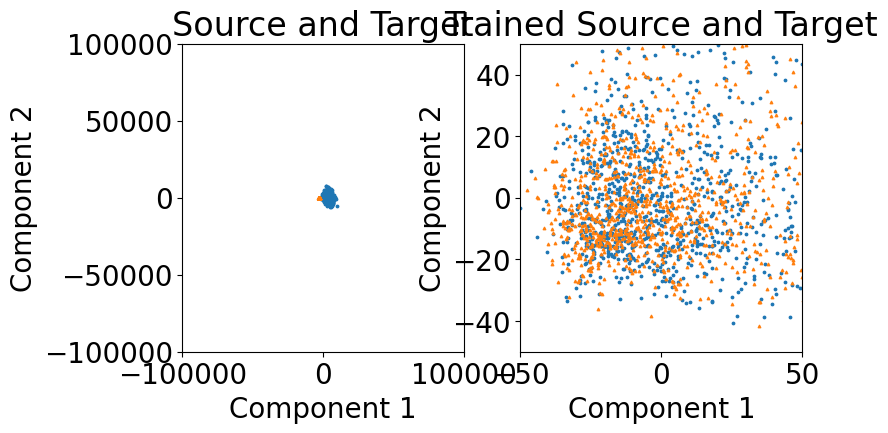

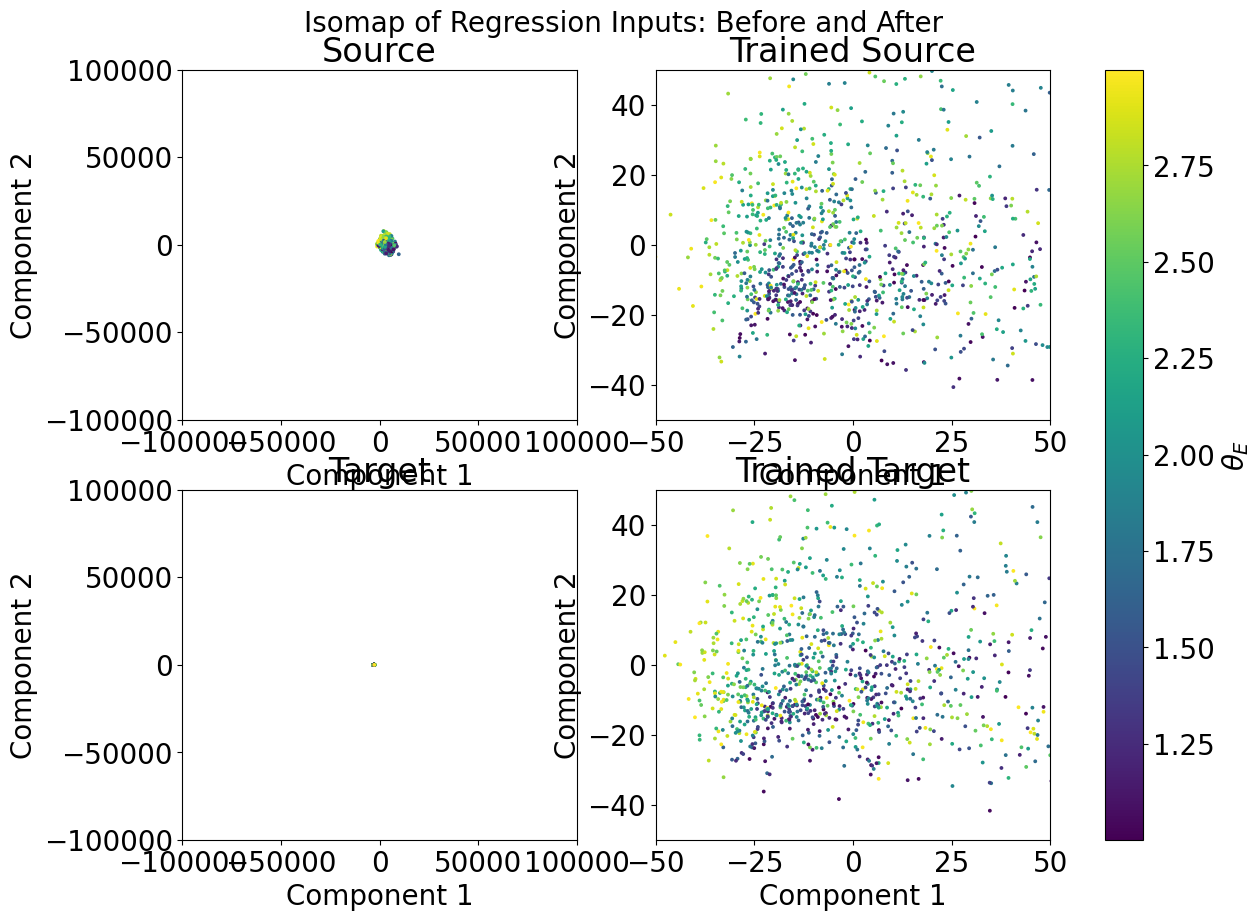

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [31]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 100000, 50)

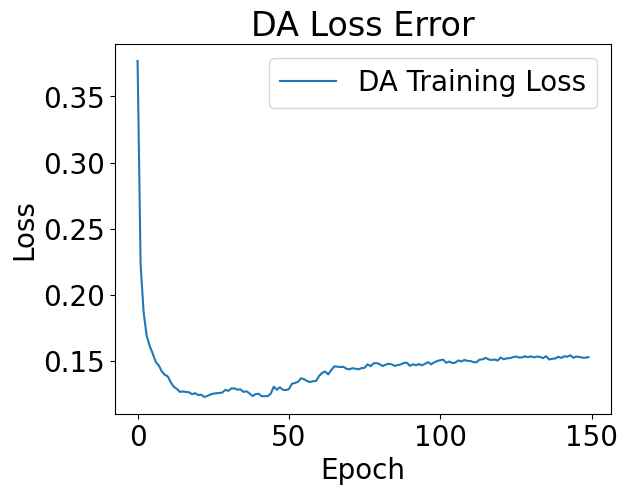

In [47]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

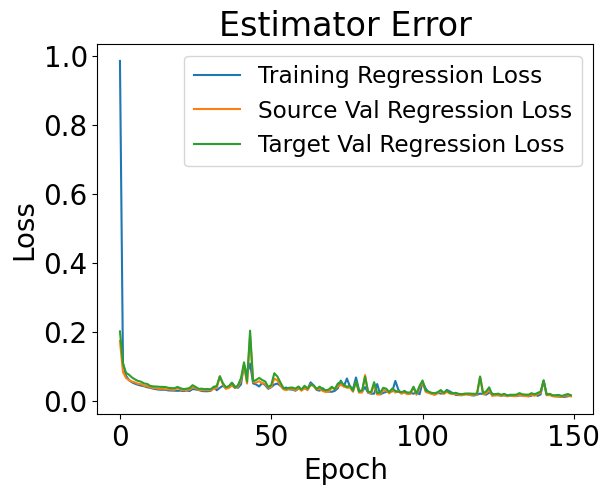

In [48]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 10.0)

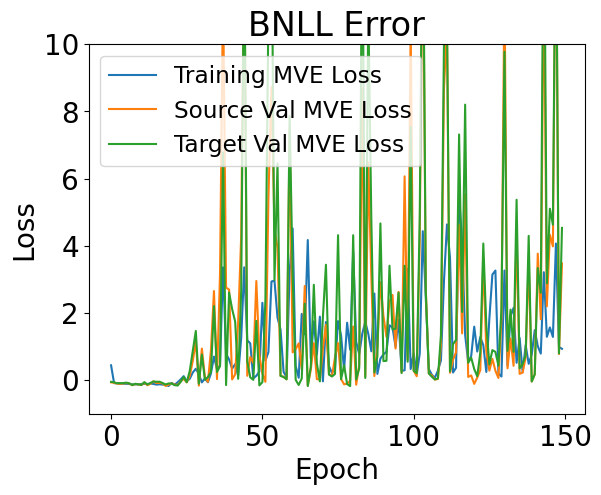

In [49]:
# Estimator
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 10)

(0.5, 1.0)

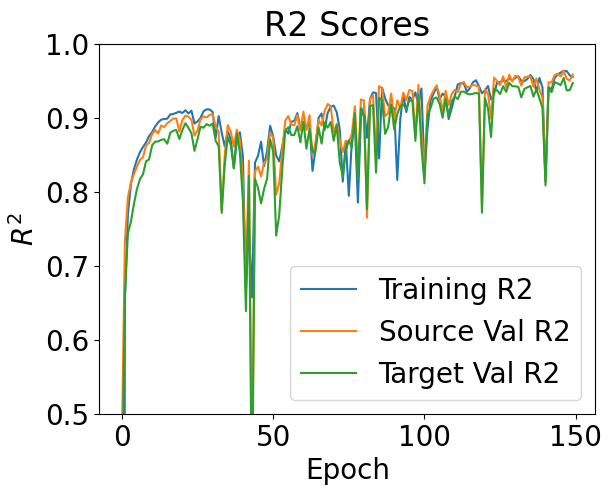

In [50]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

Source R2 Score is 0.9580


Text(0.5, 1.0, 'MMD | Source | R2: 0.958')

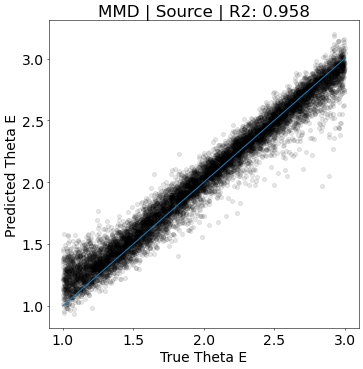

In [51]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: 0.514')

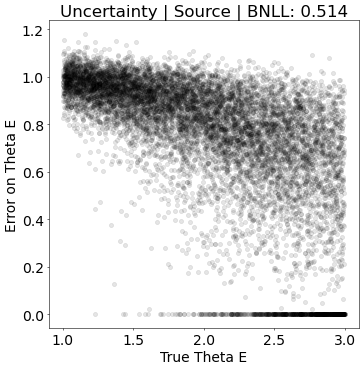

In [52]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

Target R2 Score is 0.9447


Text(0.5, 1.0, 'MMD | Target | R2: 0.945')

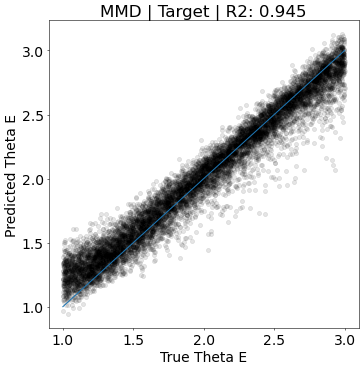

In [53]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: 0.685')

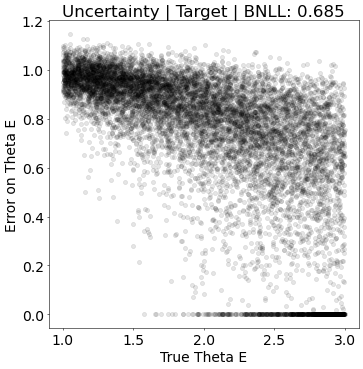

In [54]:
plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [55]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

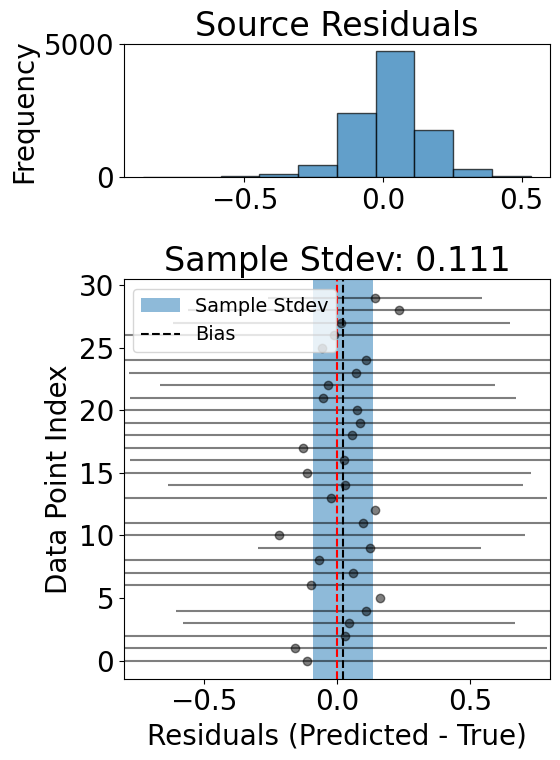

In [56]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

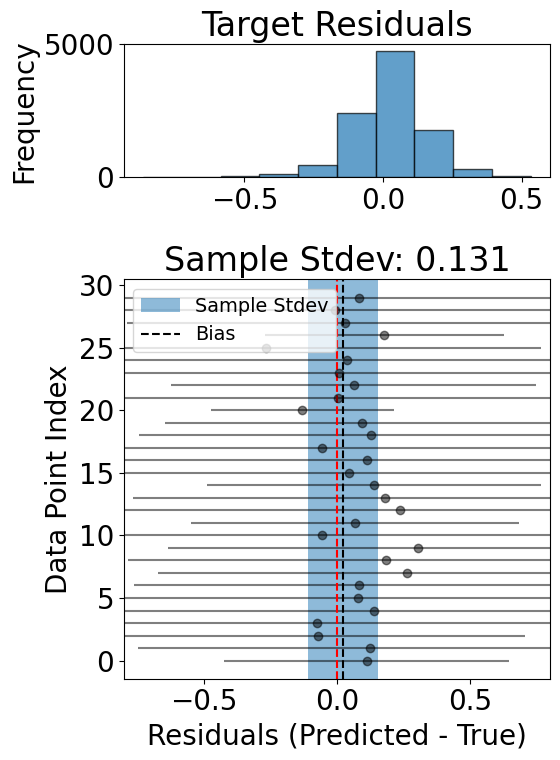

In [57]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()